# Downlad data and other preparing

In [1]:
import os
import pandas as pd
import seaborn as sns
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import timeit
import numpy as np
import time
import subprocess
%matplotlib inline

In [2]:
%load_ext rpy2.ipython

In [4]:
%%R
library(Seurat)
library(Rtsne)
library(dplyr)
library(tidyr)
library(VennDiagram)
options(stringsAsFactors = FALSE)
#library(ggcorplot)

## Two dataset of single cell RNA-seq made by 10x genomics; both samples were taken from same donor
### FIRST SAMPLE
Pan T cells isolated from mononuclear cells of a healthy donor (same donor as t_4k). T cells are primary cells with relatively small amounts of RNA (~1pg RNA/cell).
3,555 cells detected
Sequenced on Illumina Hiseq4000 with approximately 100,000 reads per cell
26bp read1 (16bp Chromium barcode and 10bp UMI), 98bp read2 (transcript), and 8bp I7 sample barcode
### SECOND SAMPLE
Pan T cells isolated from mononuclear cells of a healthy donor (same donor as t_3k). T cells are primary cells with relatively small amounts of RNA (~1pg RNA/cell).
4,538 cells detected
Sequenced on Illumina Hiseq4000 with approximately 73,000 reads per cell
26bp read1 (16bp Chromium barcode and 10bp UMI), 98bp read2 (transcript), and 8bp I7 sample barcode

In [ ]:
%%bash
#------Go to work folder------
cd /home/taumata/shared-with-me/minnn_analysis/raw_data/singlecell

#-----download data-----
#FIRST SAMPLE
wget http://s3-us-west-2.amazonaws.com/10x.files/samples/cell-exp/2.1.0/t_3k/t_3k_fastqs.tar
#SECOND SAMPLE
wget http://s3-us-west-2.amazonaws.com/10x.files/samples/cell-exp/2.1.0/t_4k/t_4k_fastqs.tar

#-----unpack------
tar -xvf t_3k_fastqs.tar
mkdir t_3k
mv fastqs t_3k

tar -xvf t_4k_fastqs.tar
mkdir t_4k
mv fastqs t_4k

We will map reads with STAR aligner [https://github.com/alexdobin/STAR], to do it we need download (eg from ENSEMBL) human genome sequence and annotation and make genome indexes. We will make two indexes - with annotation and without (zUMIs can work with that type of indexes). 

In [ ]:
%%bash
#-----Go to work folder-----
cd /home/taumata/GRCh38

#-----downlad data-----
wget ftp://ftp.ensembl.org/pub/release-94/fasta/homo_sapiens/dna//Homo_sapiens.GRCh38.dna.primary_assembly.fa.gz
wget ftp://ftp.ensembl.org/pub/release-94/gtf/homo_sapiens//Homo_sapiens.GRCh38.94.chr.gtf.gz

#-----unpack-----
gunzip Homo_sapiens.GRCh38.dna.primary_assembly.fa.gz
gunzip Homo_sapiens.GRCh38.94.chr.gtf.gz
    
#-----make genome indexes with STAR----
#first make folder where STAR will writte output (itt can nott do it itself)
#without annotation
mkdir GRCh38_STAR5idx_noGTF
./../soft/STAR-2.5.4b/bin/Linux_x86_64/STAR --runMode genomeGenerate --runThreadN 16 \
                                            --genomeDir GRCh38_STAR5idx_noGTF \
                                            --genomeFastaFiles Homo_sapiens.GRCh38.dna.primary_assembly.fa
#with annottation 
mkdir GRCh38_STAR5idx
./../soft/STAR-2.5.4b/bin/Linux_x86_64/STAR --runMode genomeGenerate --runThreadN 16 \
                                            --genomeDir GRCh38_STAR5idx \
                                            --genomeFastaFiles Homo_sapiens.GRCh38.dna.primary_assembly.fa \
                                            --sjdbGTFfile Homo_sapiens.GRCh38.94.chr.gtf

# Map reads with zUMIs
Download and install as described here https://github.com/sdparekh/zUMIs
needs samtools >= 1.5; STAR >= 2.5.4b; R >= 3.4 and pigz (must be included in PATH or must be indicated to zUMIs)

In [66]:
def runZUMIS(yaml):
    zumis='''
        /home/taumata/soft/zUMIs/zUMIs-master.sh -y %s \
                             -s /home/taumata/soft/STAR-2.5.4b/bin/Linux_x86_64/STAR \
                             -t /home/taumata/soft/samtools-1.9/samtools
                             '''%(yaml)
    os.system(zumis)

## Process First sample (t_3)
(for speed we will process only part of data)
make cofig file zUMIs_t3.yaml with online application http://shiny.bio.lmu.de:3838/zUMIs-config/


file contain:

RUN zUMIs

In [67]:
%%time
initialDir=os.getcwd()
os.chdir("/home/taumata/shared-with-me/minnn_analysis/results/singlecell")

#-----make folder for output-----
try:
    os.mkdir("zUMIs_t3")
except:
    pass
#-----run zUMIs-----
runZUMIS("zUMIs_t3.yaml")

os.chdir(initialDir)

CPU times: user 863 ms, sys: 761 ms, total: 1.62 s
Wall time: 2h 2min 40s


## Process Second sample (t_4)
(for speed we will process only part of data) make cofig file zUMIs_t3.yaml with online application http://shiny.bio.lmu.de:3838/zUMIs-config/
in config file change names of files with reads to
/home/taumata/shared-with-me/minnn_analysis/raw_data/singlecell/t_4k/f
astqs/t_4k_S1_L001_R1_001.fastq.gz
/home/taumata/shared-with-me/minnn_analysis/raw_data/singlecell/t_4k/f
astqs/t_4k_S1_L001_R1_001.fastq.gz
and output directory to
/home/taumata/shared-with-me/minnn_analysis/results/singleCell/zUMIs_t4

In [68]:
%%time
initialDir=os.getcwd()
os.chdir("/home/taumata/shared-with-me/minnn_analysis/results/singlecell")

#-----make folder for output-----
try:
    os.mkdir("zUMIs_t4")
except:
    pass
#-----run zUMIs-----
runZUMIS("zUMIs_t4.yaml")

os.chdir(initialDir)

CPU times: user 1.12 s, sys: 956 ms, total: 2.07 s
Wall time: 2h 10min 26s


# Process reads with UMI-tools, map them with STAR and count features with subread
Download and install as described here https://github.com/CGATOxford/UMI-tools
needs samtools >= 1.5; STAR >= 2.5.4b; R >= 3.4 and pigz (must be included in PATH or must be indicated to zUMIs))

In [63]:
def run_umiTools(R1,R2,outputName):

    make_whitelist = """\
            umi_tools whitelist\
                    --stdin %s \
                    --bc-pattern='(?P<cell_1>.{16})(?P<umi_1>.{10})' \
                    --extract-method=regex \
                    --plot-prefix \
                    --log2stderr > /home/taumata/shared-with-me/minnn_analysis/results/singlecell/whitelist_%s.txt
                    """%(R1,outputName)

    extract_barcodes = """\
            umi_tools extract --bc-pattern=CCCCCCCCCCCCCCCCNNNNNNNNNN \
                      --stdin %s \
                      --stdout /home/taumata/shared-with-me/minnn_analysis/results/singlecell/%s_R1_extracted.fastq.gz \
                      --read2-in %s \
                      --read2-out /home/taumata/shared-with-me/minnn_analysis/results/singlecell/%s_R2_extracted.fastq.gz \
                      --filter-cell-barcode \
                      --whitelist=/home/taumata/shared-with-me/minnn_analysis/results/singlecell/whitelist_%s.txt
                      """%(R1,outputName,R2,outputName,outputName)


    runSTAR = """\
            /home/taumata/soft/STAR-2.5.4b/bin/Linux_x86_64/STAR --runThreadN 16 \
                 --genomeDir /home/taumata/GRCh38/GRCh38_STAR5idx \
                 --readFilesIn /home/taumata/shared-with-me/minnn_analysis/results/singlecell/%s_R2_extracted.fastq.gz \
                 --readFilesCommand zcat \
                 --outFilterMultimapNmax 1 \
                 --outSAMtype BAM SortedByCoordinate
                 """%(outputName)
    
    runFeatureCounts = """\
            /home/taumata/soft/subread-1.6.3-source/bin/featureCounts \
                  -a /home/taumata/GRCh38/Homo_sapiens.GRCh38.94.chr.gtf \
                  -o gene_assigned \
                  -R BAM Aligned.sortedByCoord.out.bam \
                  -T 16 """ 

    runSamtoolsSort = """\
            samtools sort Aligned.sortedByCoord.out.bam.featureCounts.bam -o assigned_sorted.bam"""

    runSamtoolsIndex = """\
            samtools index assigned_sorted.bam"""
    
    runUmiCount = """
            umi_tools count --per-gene \
                 --gene-tag=XT --assigned-status-tag=XS \
                 --per-cell -I assigned_sorted.bam \
                 -S /home/taumata/shared-with-me/minnn_analysis/results/singlecell/%s_umitools_counts.tsv.gz
                 """%(outputName)
   
    
    os.system(make_whitelist)
    os.system(extract_barcodes)
    os.system(runSTAR)
    os.system(runFeatureCounts)
    os.system(runSamtoolsSort) 
    os.system(runSamtoolsIndex)
    os.system(runUmiCount)

## Process First sample (t_3)
(for speed we will process only part of data

In [64]:
%%time
R1="/home/taumata/shared-with-me/minnn_analysis/raw_data/singlecell/t_3k/fastqs/t_3k_S1_L001_R1_001.fastq.gz"
R2="/home/taumata/shared-with-me/minnn_analysis/raw_data/singlecell/t_3k/fastqs/t_3k_S1_L001_R2_001.fastq.gz"
outputName="t3_umiTools"

run_umiTools(R1,R2,outputName)

CPU times: user 265 ms, sys: 340 ms, total: 604 ms
Wall time: 2h 13min 35s


## Process Second sample (t_4)
(for speed we will process only part of data)


In [5]:
%%time
R1="/home/taumata/shared-with-me/minnn_analysis/raw_data/singlecell/t_4k/fastqs/t_4k_S1_L001_R1_001.fastq.gz"
R2="/home/taumata/shared-with-me/minnn_analysis/raw_data/singlecell/t_4k/fastqs/t_4k_S1_L001_R2_001.fastq.gz"
outputName="t4_umiTools"

run_umiTools(R1,R2,outputName)

CPU times: user 8 µs, sys: 2 µs, total: 10 µs
Wall time: 22.9 µs


# Time to MiNNN !!!
Download and install as described here https://minnn.readthedocs.io/en/latest/

In [34]:
def run_minnn_OLD(R1,R2,outputName):
    
    minnn_extract = """\
        minnn extract -f \
            --score-threshold -25 \
              --bitap-max-errors 5 \
              --threads 16 \
              --pattern "(FULL:(BC:^nnnnnnnnnnnnnnnn)(UMI:nnnnnnnnnn$))\*" \
              --input %s %s \
              --output /home/taumata/shared-with-me/minnn_analysis/results/singlecell/extracted-%s.mif
    """%(R1,R2,outputName)
    
    minnn_correct = """\
        minnn correct -f \
            --groups UMI BC \
              --input /home/taumata/shared-with-me/minnn_analysis/results/singlecell/extracted-%s.mif \
              --output /home/taumata/shared-with-me/minnn_analysis/results/singlecell/corrected-%s.mif
    """%(outputName, outputName)
    
    minnn_sort = """\
        minnn sort \
            -f \
            --groups UMI \
            --input /home/taumata/shared-with-me/minnn_analysis/results/singlecell/corrected-%s.mif \
            --output /home/taumata/shared-with-me/minnn_analysis/results/singlecell/sorted-%s.mif
    """%(outputName, outputName)
    
    minnn_consensus = """\
        minnn consensus -Xmx30G \
            -f \
            --threads 16 \
            --groups UMI \
            --input /home/taumata/shared-with-me/minnn_analysis/results/singlecell/sorted-%s.mif \
            --output /home/taumata/shared-with-me/minnn_analysis/results/singlecell/consensus-%s.mif
    """%(outputName, outputName)
    
    minnn_2fastq = """\
        minnn mif2fastq \
            -f \
            --input /home/taumata/shared-with-me/minnn_analysis/results/singlecell/consensus-%s.mif  \
            --group R1=/home/taumata/shared-with-me/minnn_analysis/results/singlecell/R1-%s.fastq \
            R2=/home/taumata/shared-with-me/minnn_analysis/results/singlecell/R2-%s.fastq
        """ % (outputName,outputName,outputName)

    #print(minnn_extract)
    #print(minnn_correct)
    #print(minnn_sort)
    #print(minnn_consensus)
    #print(minnn_2fastq)
    os.system(minnn_extract)
    os.system(minnn_correct)
    os.system(minnn_sort)
    os.system(minnn_consensus)
    os.system(minnn_2fastq)

def runSTARparallel(fileName):
    os.system("/home/taumata/soft/STAR-2.5.4b/bin/Linux_x86_64/STAR \
                        --genomeDir /home/taumata/GRCh38/GRCh38_STAR5idx \
                        --genomeLoad LoadAndExit")
    
    os.system("""parallel -j 4 -a %s --colsep '\t' /home/taumata/soft/STAR-2.5.4b/bin/Linux_x86_64/STAR \
                                            --runThreadN 4 \
                                            --genomeDir /home/taumata/GRCh38/GRCh38_STAR5idx \
                                            --outFilterMultimapNmax 1 \
                                            --outSAMtype BAM SortedByCoordinate \
                                            --readFilesIn /home/taumata/shared-with-me/minnn_analysis/results/singlecell/t4_minnn/R2-{2}.fastq \
                                            --outFileNamePrefix /home/taumata/shared-with-me/minnn_analysis/results/singlecell/t4_minnn/{2} \
                                            """%(fileName))
    os.system("/home/taumata/soft/STAR-2.5.4b/bin/Linux_x86_64/STAR \
                        --genomeDir /home/taumata/GRCh38/GRCh38_STAR5idx \
                        --genomeLoad Remove")

In [45]:
def run_minnn_extract(R1,R2,outputName,workingDirectory):
    
    minnn_extract = """\
        minnn extract -f \
            --score-threshold 0 \
              --bitap-max-errors 0 \
              --threads 60 \
              --pattern "^(FULL:(BC:NNNNNNNNNNNNNNNN)(UMI:NNNNNNNNNN))$\*" \
              --input %s %s \
              --output %s/extracted-%s.mif
    """%(R1,R2,workingDirectory,outputName)
    
    os.system(minnn_extract)

def run_minnn_BC_correcttion(outputName,workingDirectory):
    
    
    minnn_correct = """\
        minnn correct -f \
            --groups BC \
              --input %s/extracted-%s.mif \
              --output %s/corrected-%s.mif
    """%(workingDirectory,outputName,
         workingDirectory, outputName)
    
    #stat-groups instead of minnn_2fastq
    
    minnn_2fastq = """\
        minnn mif2fastq \
            -f \
            --input %s/corrected-%s.mif  \
            --group R1=%s/R1-barcode_c-%s.fastq \
            R2=%s/R2-barcode_c-%s.fastq
        """ % (workingDirectory,outputName,
               workingDirectory,outputName,
               workingDirectory,outputName)
    
    
    os.system(minnn_correct)
    os.system(minnn_2fastq)


def run_minnn_sort(sampleName,workingDirectory):

    minnn_sort = """\
        minnn -Xmx100G sort \
            -f \
            --chunk-size 1000000\
            --groups UMI \
            --input %s/corrected-%s.mif \
            --output %s/sorted-%s.mif
        """%(workingDirectory, sampleName,
             workingDirectory, sampleName)
    
    os.system(minnn_sort)
    
    
    
def run_minnn_demultiplex(sampleName,workingDirectory):
    
    minnn_demultiplex="""\
        minnn demultiplex --by-sample -f \
            --demultiplex-log %s/%s_demux_log \
            %s/%s_umi_samples.txt  \
            %s/corrected-%s.mif
        """%(workingDirectory,sampleName,
              workingDirectory,sampleName,
              workingDirectory,sampleName)
    
    os.system(minnn_demultiplex)

    
def run_minnn_parallel(metaFileName,workingDirectory):
    
    os.system("""parallel -j 60 -a %s/%s --colsep '\t' minnn correct -f \
                                            --groups UMI \
                                            --input {1} \
                                            --output %s/UMIcorrected-{2}.mif \
                                            """%(workingDirectory,metaFileName,workingDirectory))
   
    os.system("""parallel -j 60 -a %s/%s --colsep '\t' minnn sort -f \
                                            --groups UMI \
                                            --input %s/UMIcorrected-{2}.mif \
                                            --output %s/UMIsorted-{2}.mif \
                                            """%(workingDirectory,metaFileName,
                                                 workingDirectory,workingDirectory))    
       

    os.system("""parallel -j 60 -a %s/%s --colsep '\t' minnn consensus -Xmx1G -f \
                                            --groups UMI \
                                            --consensus-algorithm single-cell \
                                            --threads 1 \
                                            --input %s/UMIsorted-{2}.mif \
                                            --output %s/UMIconsensus-{2}.mif \
                                            """%(workingDirectory,metaFileName,
                                                 workingDirectory,workingDirectory)) 
    
    os.system("""parallel -j 60 -a %s/%s --colsep '\t' minnn mif2fastq -f \
                                            --input %s/UMIconsensus-{2}.mif \
                                            --group R1=%s/R1-{2}.fastq \
                                                    R2=%s/R2-{2}.fastq \
                                            """%(workingDirectory,metaFileName,
                                                 workingDirectory,workingDirectory,workingDirectory))
    
def run_minnn_parallel_part(metaFileName,workingDirectory):
    
    os.system("""parallel -j 60 -a %s/%s --colsep '\t' minnn consensus -Xmx6G -f \
                                            --groups UMI \
                                            --threads 1 \
                                            --consensus-algorithm single-cell \
                                            --input %s/UMIsorted-{2}.mif \
                                            --output %s/UMIconsensus-{2}.mif \
                                            """%(workingDirectory,metaFileName,
                                                 workingDirectory,workingDirectory)) 

    
    os.system("""parallel -j 60 -a %s/%s --colsep '\t' minnn mif2fastq -f \
                                            --input %s/UMIconsensus-{2}.mif \
                                            --group R1=%s/R1-{2}.fastq \
                                                    R2=%s/R2-{2}.fastq \
                                            """%(workingDirectory,metaFileName,
                                                 workingDirectory,workingDirectory,workingDirectory)) 
    


def runSTAR(sampleName,workingDirectory):
    
    runstar='''\
        /home/taumata/soft/STAR-2.5.4b/bin/Linux_x86_64/STAR \
                  --runThreadN 16 \
                  --genomeDir /home/taumata/GRCh38/GRCh38_STAR5idx \
                  --outFilterMultimapNmax 1 \
                  --outSAMtype BAM SortedByCoordinate \
                  --readFilesIn %s/%s \
                  --outFileNamePrefix %s/%s_map_ \
                  '''%(workingDirectory,sampleName,
                       workingDirectory,sampleName)    
    
    os.system(runstar)
    
    
def runFeatureCount(sampleName,workingDirectory):
    runfc='''\
        /home/taumata/soft/subread-1.6.3-source/bin/featureCounts \
                  -a /home/taumata/GRCh38/Homo_sapiens.GRCh38.94.chr.gtf \
                  -o %s/gene_assigned_%s \
                  -R CORE \
                  -T 60 \
                  %s/%s_map_Aligned.sortedByCoord.out.bam  \
                  '''%(workingDirectory,sampleName,
                      workingDirectory,sampleName)
    #print(runfc)
    os.system(runfc)
    


#allCells.fastq_map_Aligned.sortedByCoord.out.bam

In [40]:
def run_minnn_extract_10xGE(R1,R2,outputName,workingDirectory):
    
    minnn_extract = """\
        minnn extract -f \
            --oriented \
            --score-threshold 0 \
              --bitap-max-errors 0 \
              --threads 60 \
              --pattern "^(FULL:(BC:NNNNNNNNNNNNNNNN)(UMI:NNNNNNNNNN))$\*" \
              --input %s %s \
              --output %s/extracted-%s.mif
    """%(R1,R2,workingDirectory,outputName)
    
    os.system(minnn_extract)


def run_minnn_BC_correcttion(outputName,workingDirectory):
    
    
    minnn_correct = """\
        minnn correct -f \
            --groups BC \
              --input %s/extracted-%s.mif \
              --output %s/corrected-%s.mif 
    """%(workingDirectory,outputName,
         workingDirectory, outputName)
    
    print(minnn_correct)
    os.system(minnn_correct)    
    
    
def run_minnn_stat_groups(sampleName,workingDirectory):
    
    minnn_stat_groups = """\
        minnn stat-groups -f \
                          --groups BC \
                          --input %s/%s.mif \
                          --output %s/statgroup-%s.txt
                          """%(workingDirectory,sampleName,
                              workingDirectory,sampleName)
    
    print(minnn_stat_groups)
    os.system(minnn_stat_groups)
    
    
def run_minnn_BC_filter(outputName,workingDirectory,maxBarcodes):
    
    
    minnn_correct = """\
        minnn correct -f \
            --groups BC \
              --max-total-errors 0 \
              --input %s/corrected-%s.mif \
              --output %s/filtred-%s.mif \
              --max-unique-barcodes %s
    """%(workingDirectory,outputName,
         workingDirectory, outputName,maxBarcodes)
    
    print(minnn_correct)
    os.system(minnn_correct)
        
def run_minnn_sort_BC(sampleName,workingDirectory):

    minnn_sort = """\
        minnn -Xmx100G sort \
            -f \
            --chunk-size 1000000\
            --groups BC \
            --input %s/filtred-%s.mif \
            --output %s/sorted-%s.mif
        """%(workingDirectory, sampleName,
             workingDirectory, sampleName)
    print(minnn_sort)
    os.system(minnn_sort)
        
def run_minnn_UMI_correcttion(sampleName,workingDirectory):
    
    
    minnn_correct = """\
        minnn correct -f \
            --primary-groups BC \
            --groups UMI \
              --input %s/sorted-%s.mif \
              --output %s/UMI-corrected-%s.mif 
    """%(workingDirectory,sampleName,
         workingDirectory, sampleName)
    
    print(minnn_correct)
    os.system(minnn_correct)

def run_minnn_sort_BC_UMI(sampleName,workingDirectory):

    minnn_sort = """\
        minnn -Xmx100G sort \
            -f \
            --chunk-size 1000000\
            --groups BC UMI\
            --input %s/UMI-corrected-%s.mif \
            --output %s/BC_UMI-sorted-%s.mif
        """%(workingDirectory, sampleName,
             workingDirectory, sampleName)
    
    os.system(minnn_sort)   
    
    
def run_minnn_consensus(sampleName,workingDirectory):
    
    minnn_consensus="""minnn consensus -Xmx60G -f \
                                            --groups BC UMI \
                                            --threads 60 \
                                            --input %s/BC_UMI-sorted-%s.mif \
                                            --output %s/consensus-%s.mif \
                                            """%(workingDirectory,sampleName,
                                                 workingDirectory,sampleName)
    
    
    print(minnn_consensus)
    os.system(minnn_consensus)     

## Process First sample (t_3)
(for speed we will process only part of data)

First, save folder names into variables

In [14]:
R1="/home/taumata/shared-with-me/minnn_analysis/raw_data/singlecell/t_3k/fastqs/t_3k_S1_L001_R1_001.fastq.gz"
R2="/home/taumata/shared-with-me/minnn_analysis/raw_data/singlecell/t_3k/fastqs/t_3k_S1_L001_R2_001.fastq.gz"
sampleName="t3_minnn"
workingDirectory="/home/taumata/shared-with-me/minnn_analysis/results/singlecell"
#---------------------------------------
newDirectory=str(workingDirectory)+"/"+str(sampleName) #will be used from demultiplexing step
try:
    os.mkdir(str(newDirectory))
except:
    pass

Next, exctract barcodes

In [15]:
%%time
print(time.ctime())
run_minnn_extract_10xGE(R1,R2,sampleName,newDirectory)
print(time.ctime())

Sat Feb 23 19:36:26 2019
Sat Feb 23 19:45:25 2019
CPU times: user 3.56 ms, sys: 44.7 ms, total: 48.3 ms
Wall time: 8min 58s


### UMI distribution between cells before cell barcode correction

Sat Feb 23 21:24:45 2019
        minnn stat-groups -f                           --groups BC                           --input /home/taumata/shared-with-me/minnn_analysis/results/singlecell/t3_minnn/extracted-t3_minnn.mif                           --output /home/taumata/shared-with-me/minnn_analysis/results/singlecell/t3_minnn/statgroup-extracted-t3_minnn.txt
                          
Sat Feb 23 21:29:11 2019
3927
CPU times: user 9.52 s, sys: 274 ms, total: 9.79 s
Wall time: 4min 27s


/home/taumata/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


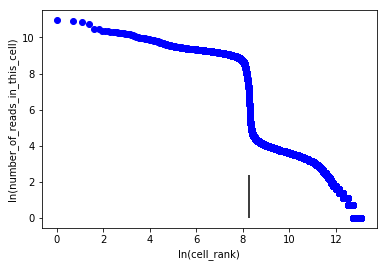

In [24]:
%%time
print(time.ctime())
run_minnn_stat_groups("extracted-"+str(sampleName),newDirectory)
print(time.ctime())

readInCell=pd.read_csv(str(newDirectory)+"/statgroup-extracted-"+str(sampleName)+".txt",
                                sep=" ",header=0)
#readInCell.loc[:,"logCount"]=np.log(readInCell.loc[:,"count"])
cellSizeReads=np.log(readInCell.loc[:,"count"])
rawdiff=np.diff(np.log(sorted(cellSizeReads,reverse=True)))/np.diff(range(len(cellSizeReads)))
inflPoin=np.argmin(rawdiff[1000:20000])+1000  #we know that there are more than 1000 cells and surely less than 20000

print(inflPoin)

plt.plot(np.log(range(len(cellSizeReads))),sorted(cellSizeReads,reverse=True),"bo")
plt.xlabel("ln(cell_rank)")
plt.ylabel("ln(number_of_reads_in_this_cell)")
plt.vlines(np.log(inflPoin),0,sorted(cellSizeReads,reverse=True)[0])

Now, correct cell barcodes

In [16]:
%%time
print(time.ctime())
run_minnn_BC_correcttion(sampleName,newDirectory)
print(time.ctime())

Sat Feb 23 19:45:25 2019
        minnn correct -f             --groups BC               --input /home/taumata/shared-with-me/minnn_analysis/results/singlecell/t3_minnn/extracted-t3_minnn.mif               --output /home/taumata/shared-with-me/minnn_analysis/results/singlecell/t3_minnn/corrected-t3_minnn.mif 
    
Sat Feb 23 20:16:51 2019
CPU times: user 46.4 ms, sys: 39.5 ms, total: 85.9 ms
Wall time: 31min 25s


### UMI distribution between cells after cell barcode correction, find how many cells have enought reads

Sat Feb 23 21:32:55 2019
        minnn stat-groups -f                           --groups BC                           --input /home/taumata/shared-with-me/minnn_analysis/results/singlecell/t3_minnn/corrected-t3_minnn.mif                           --output /home/taumata/shared-with-me/minnn_analysis/results/singlecell/t3_minnn/statgroup-corrected-t3_minnn.txt
                          
Sat Feb 23 21:36:47 2019
4005
CPU times: user 90.9 ms, sys: 43.4 ms, total: 134 ms
Wall time: 3min 52s


/home/taumata/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


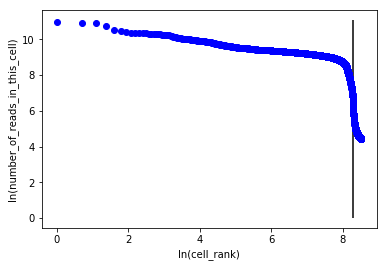

In [25]:
%%time
print(time.ctime())
run_minnn_stat_groups("corrected-"+str(sampleName),newDirectory)
print(time.ctime())

readInCell=pd.read_csv(str(newDirectory)+"/statgroup-corrected-"+str(sampleName)+".txt",
                                sep=" ",header=0)
#readInCell.loc[:,"logCount"]=np.log(readInCell.loc[:,"count"])
cellSizeReads=np.log(readInCell.loc[:,"count"])
rawdiff=np.diff(np.log(sorted(cellSizeReads,reverse=True)))/np.diff(range(len(cellSizeReads)))
inflPoin=np.argmin(rawdiff[1000:20000])+1000  #we know that there are more than 1000 cells and surely less than 20000

print(inflPoin)

plt.plot(np.log(range(len(cellSizeReads))),sorted(cellSizeReads,reverse=True),"bo")
plt.xlabel("ln(cell_rank)")
plt.ylabel("ln(number_of_reads_in_this_cell)")
plt.vlines(np.log(inflPoin),0,sorted(cellSizeReads,reverse=True)[0])

### filter cells with small number of UMIs

In [35]:
%%time
print(time.ctime())
run_minnn_BC_filter(sampleName,newDirectory,inflPoin)
print(time.ctime())

Sat Feb 23 22:01:54 2019
        minnn correct -f             --groups BC               --max-total-errors 0               --input /home/taumata/shared-with-me/minnn_analysis/results/singlecell/t3_minnn/corrected-t3_minnn.mif               --output /home/taumata/shared-with-me/minnn_analysis/results/singlecell/t3_minnn/filtred-t3_minnn.mif               --max-unique-barcodes 4005
    
Sat Feb 23 22:15:51 2019
CPU times: user 16.8 ms, sys: 48.1 ms, total: 64.8 ms
Wall time: 13min 56s


In [41]:
%%time
print(time.ctime())
run_minnn_sort_BC(sampleName,newDirectory)
print(time.ctime())

Sun Feb 24 10:29:17 2019
        minnn -Xmx100G sort             -f             --chunk-size 1000000            --groups BC             --input /home/taumata/shared-with-me/minnn_analysis/results/singlecell/t3_minnn/filtred-t3_minnn.mif             --output /home/taumata/shared-with-me/minnn_analysis/results/singlecell/t3_minnn/sorted-t3_minnn.mif
        
Sun Feb 24 10:53:00 2019
CPU times: user 49.4 ms, sys: 40.5 ms, total: 89.8 ms
Wall time: 23min 43s


In [42]:
%%time
print(time.ctime())
run_minnn_UMI_correcttion(sampleName,newDirectory)
print(time.ctime())

Sun Feb 24 10:53:00 2019
        minnn correct -f             --primary-groups BC             --groups UMI               --input /home/taumata/shared-with-me/minnn_analysis/results/singlecell/t3_minnn/sorted-t3_minnn.mif               --output /home/taumata/shared-with-me/minnn_analysis/results/singlecell/t3_minnn/UMI-corrected-t3_minnn.mif 
    
Sun Feb 24 13:51:00 2019
CPU times: user 177 ms, sys: 222 ms, total: 398 ms
Wall time: 2h 58min


In [43]:
%%time
print(time.ctime())
run_minnn_sort_BC_UMI(sampleName,newDirectory)
print(time.ctime())

Sun Feb 24 13:51:00 2019
Sun Feb 24 14:13:06 2019
CPU times: user 40.5 ms, sys: 40.5 ms, total: 81 ms
Wall time: 22min 5s


In [44]:
%%time
print(time.ctime())
run_minnn_consensus(sampleName,newDirectory)
print(time.ctime())

Sun Feb 24 14:13:06 2019
minnn consensus -Xmx60G -f                                             --groups BC UMI                                             --threads 60                                             --input /home/taumata/shared-with-me/minnn_analysis/results/singlecell/t3_minnn/BC_UMI-sorted-t3_minnn.mif                                             --output /home/taumata/shared-with-me/minnn_analysis/results/singlecell/t3_minnn/consensus-t3_minnn.mif                                             
Sun Feb 24 14:43:34 2019
CPU times: user 86.5 ms, sys: 38.1 ms, total: 125 ms
Wall time: 30min 28s


## Process Second sample (t_4)
(for speed we will process only part of data)

In [46]:
R1="/home/taumata/shared-with-me/minnn_analysis/raw_data/singlecell/t_4k/fastqs/t_4k_S1_L001_R1_001.fastq.gz"
R2="/home/taumata/shared-with-me/minnn_analysis/raw_data/singlecell/t_4k/fastqs/t_4k_S1_L001_R2_001.fastq.gz"
sampleName="t4_minnn"
workingDirectory="/home/taumata/shared-with-me/minnn_analysis/results/singlecell"
#---------------------------------------
newDirectory=str(workingDirectory)+"/"+str(sampleName) #will be used from demultiplexing step
try:
    os.mkdir(str(newDirectory))
except:
    pass

Sun Feb 24 15:34:21 2019
Sun Feb 24 15:43:01 2019
        minnn stat-groups -f                           --groups BC                           --input /home/taumata/shared-with-me/minnn_analysis/results/singlecell/t4_minnn/extracted-t4_minnn.mif                           --output /home/taumata/shared-with-me/minnn_analysis/results/singlecell/t4_minnn/statgroup-extracted-t4_minnn.txt
                          
Sun Feb 24 15:47:15 2019
19680
Sun Feb 24 15:47:16 2019
        minnn correct -f             --groups BC               --input /home/taumata/shared-with-me/minnn_analysis/results/singlecell/t4_minnn/extracted-t4_minnn.mif               --output /home/taumata/shared-with-me/minnn_analysis/results/singlecell/t4_minnn/corrected-t4_minnn.mif 
    


/home/taumata/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


Sun Feb 24 16:19:36 2019
        minnn stat-groups -f                           --groups BC                           --input /home/taumata/shared-with-me/minnn_analysis/results/singlecell/t4_minnn/corrected-t4_minnn.mif                           --output /home/taumata/shared-with-me/minnn_analysis/results/singlecell/t4_minnn/statgroup-corrected-t4_minnn.txt
                          
Sun Feb 24 16:23:09 2019
4900
Sun Feb 24 16:23:09 2019
        minnn correct -f             --groups BC               --max-total-errors 0               --input /home/taumata/shared-with-me/minnn_analysis/results/singlecell/t4_minnn/corrected-t4_minnn.mif               --output /home/taumata/shared-with-me/minnn_analysis/results/singlecell/t4_minnn/filtred-t4_minnn.mif               --max-unique-barcodes 4900
    


/home/taumata/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log


Sun Feb 24 16:36:11 2019
        minnn -Xmx100G sort             -f             --chunk-size 1000000            --groups BC             --input /home/taumata/shared-with-me/minnn_analysis/results/singlecell/t4_minnn/filtred-t4_minnn.mif             --output /home/taumata/shared-with-me/minnn_analysis/results/singlecell/t4_minnn/sorted-t4_minnn.mif
        
Sun Feb 24 16:58:32 2019
        minnn correct -f             --primary-groups BC             --groups UMI               --input /home/taumata/shared-with-me/minnn_analysis/results/singlecell/t4_minnn/sorted-t4_minnn.mif               --output /home/taumata/shared-with-me/minnn_analysis/results/singlecell/t4_minnn/UMI-corrected-t4_minnn.mif 
    
Sun Feb 24 20:05:02 2019
Sun Feb 24 20:25:41 2019
minnn consensus -Xmx60G -f                                             --groups BC UMI                                             --threads 60                                             --input /home/taumata/shared-with-me/minnn_analysis/re

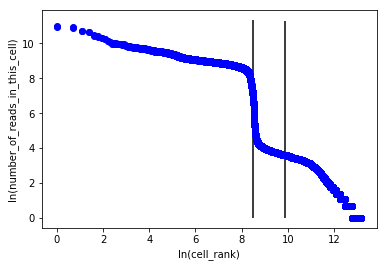

In [47]:
%%time
print(time.ctime())
run_minnn_extract_10xGE(R1,R2,sampleName,newDirectory)

print(time.ctime())
run_minnn_stat_groups("extracted-"+str(sampleName),newDirectory)
print(time.ctime())

readInCell=pd.read_csv(str(newDirectory)+"/statgroup-extracted-"+str(sampleName)+".txt",
                                sep=" ",header=0)
#readInCell.loc[:,"logCount"]=np.log(readInCell.loc[:,"count"])
cellSizeReads=np.log(readInCell.loc[:,"count"])
rawdiff=np.diff(np.log(sorted(cellSizeReads,reverse=True)))/np.diff(range(len(cellSizeReads)))
inflPoin=np.argmin(rawdiff[1000:20000])+1000  #we know that there are more than 1000 cells and surely less than 20000

print(inflPoin)

plt.plot(np.log(range(len(cellSizeReads))),sorted(cellSizeReads,reverse=True),"bo")
plt.xlabel("ln(cell_rank)")
plt.ylabel("ln(number_of_reads_in_this_cell)")
plt.vlines(np.log(inflPoin),0,sorted(cellSizeReads,reverse=True)[0])

print(time.ctime())
run_minnn_BC_correcttion(sampleName,newDirectory)
print(time.ctime())


run_minnn_stat_groups("corrected-"+str(sampleName),newDirectory)
print(time.ctime())

readInCell=pd.read_csv(str(newDirectory)+"/statgroup-corrected-"+str(sampleName)+".txt",
                                sep=" ",header=0)
#readInCell.loc[:,"logCount"]=np.log(readInCell.loc[:,"count"])
cellSizeReads=np.log(readInCell.loc[:,"count"])
rawdiff=np.diff(np.log(sorted(cellSizeReads,reverse=True)))/np.diff(range(len(cellSizeReads)))
inflPoin=np.argmin(rawdiff[1000:20000])+1000  #we know that there are more than 1000 cells and surely less than 20000

print(inflPoin)

plt.plot(np.log(range(len(cellSizeReads))),sorted(cellSizeReads,reverse=True),"bo")
plt.xlabel("ln(cell_rank)")
plt.ylabel("ln(number_of_reads_in_this_cell)")
plt.vlines(np.log(inflPoin),0,sorted(cellSizeReads,reverse=True)[0])

print(time.ctime())
run_minnn_BC_filter(sampleName,newDirectory,inflPoin)
print(time.ctime())


run_minnn_sort_BC(sampleName,newDirectory)
print(time.ctime())


run_minnn_UMI_correcttion(sampleName,newDirectory)
print(time.ctime())


run_minnn_sort_BC_UMI(sampleName,newDirectory)
print(time.ctime())


run_minnn_consensus(sampleName,newDirectory)
print(time.ctime())

5042


/home/taumata/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


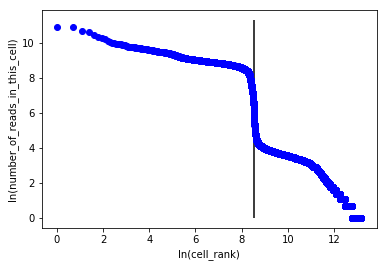

In [52]:
readInCell=pd.read_csv(str(newDirectory)+"/statgroup-extracted-"+str(sampleName)+".txt",
                                sep=" ",header=0)
#readInCell.loc[:,"logCount"]=np.log(readInCell.loc[:,"count"])
cellSizeReads=np.log(readInCell.loc[:,"count"])
rawdiff=np.diff(np.log(sorted(cellSizeReads,reverse=True)))/np.diff(range(len(cellSizeReads)))
inflPoin=np.argmin(rawdiff[2000:18000])+2000  #we know that there are more than 1000 cells and surely less than 20000

print(inflPoin)

plt.plot(np.log(range(len(cellSizeReads))),sorted(cellSizeReads,reverse=True),"bo")
plt.xlabel("ln(cell_rank)")
plt.ylabel("ln(number_of_reads_in_this_cell)")
plt.vlines(np.log(inflPoin),0,sorted(cellSizeReads,reverse=True)[0])

4900


/home/taumata/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


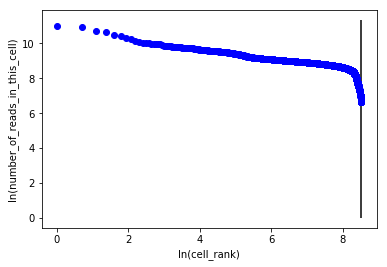

In [50]:
readInCell=pd.read_csv(str(newDirectory)+"/statgroup-corrected-"+str(sampleName)+".txt",
                                sep=" ",header=0)
#readInCell.loc[:,"logCount"]=np.log(readInCell.loc[:,"count"])
cellSizeReads=np.log(readInCell.loc[:,"count"])
rawdiff=np.diff(np.log(sorted(cellSizeReads,reverse=True)))/np.diff(range(len(cellSizeReads)))
inflPoin=np.argmin(rawdiff[1000:20000])+1000  #we know that there are more than 1000 cells and surely less than 20000

print(inflPoin)

plt.plot(np.log(range(len(cellSizeReads))),sorted(cellSizeReads,reverse=True),"bo")
plt.xlabel("ln(cell_rank)")
plt.ylabel("ln(number_of_reads_in_this_cell)")
plt.vlines(np.log(inflPoin),0,sorted(cellSizeReads,reverse=True)[0])



3948


/home/taumata/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log


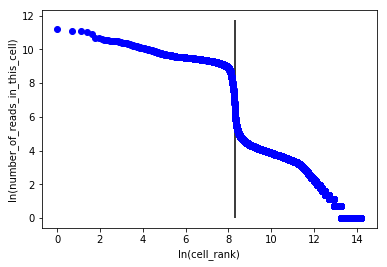

In [64]:
readInCell={}

with open(str(workingDirectory)+"/R1-barcode_c-"+str(sampleName)+".fastq","r") as inFile:
        for line in inFile:
                if line.startswith("@"):
                    temp=line.split("~")
                    if temp[1] not in readInCell: 
                        readInCell[temp[1]]=0
                    readInCell[temp[1]]+=1
    
cellSizeReads=[]
for cell in readInCell:
    cellSizeReads.append(readInCell[cell])
    
rawdiff=np.diff(np.log(sorted(cellSizeReads,reverse=True)))/np.diff(range(len(cellSizeReads)))
inflPoin=np.argmin(rawdiff[1000:20000])+1000  #we know that there are more than 1000 cells and surely less than 20000

print(inflPoin)

plt.plot(np.log(range(len(cellSizeReads))),np.log(sorted(cellSizeReads,reverse=True)),"bo")
plt.xlabel("ln(cell_rank)")
plt.ylabel("ln(number_of_reads_in_this_cell)")
plt.vlines(np.log(inflPoin),0,np.log(sorted(cellSizeReads,reverse=True))[0])


Demultiplex data and rest only cells with enough reads

In [10]:
%%time
#----------SELECT CELLS WITH ENOUGH NUMBER OF READS

goodCells=set()
enoughReads=sorted(cellSizeReads,reverse=True)[inflPoin]
for cell in readInCell:
    if readInCell[cell]>=enoughReads:
        goodCells.add(cell)
print(len(goodCells))

with open(str(newDirectory)+"/"+str(sampleName)+"_umi_samples.txt","w") as out:
    out.write("Sample\tBC")
    for bc in goodCells:
        out.write("\n"+"\t".join([bc,bc]))
        
#-----------DEMULTIPLEXING SAVING ONLY GOOD CELLS

#insert sort here and do not sort latter!!!!!!!!!!!!!!!!!

os.system("""cp %s/corrected-%s.mif %s/corrected-%s.mif"""%(workingDirectory,sampleName,
                                                                newDirectory,sampleName))        

#print("SORT")
#run_minnn_sort(sampleName,workingDirectory)
print("DEMULTIPLEXING")
run_minnn_demultiplex(sampleName,newDirectory)


#-----------MAKE META FILE
print("MAKE META FILE")
with open(str(newDirectory)+"/paral_jobs","w") as outFile:
    with open(str(newDirectory)+"/"+str(sampleName)+"_demux_log","r") as inFile:
        for line in inFile:
            line=line.strip()
            name=line.split("_")[-1]
            name=name.split(".")[0]
            outFile.write(str(line)+"\t"+str(name)+"\n")

3949
DEMULTIPLEXING
MAKE META FILE
CPU times: user 1.32 s, sys: 129 ms, total: 1.45 s
Wall time: 3h 46min 17s


Processing time: 224.17m
Processed 44765994 reads, matched 37822451 reads (84.49%)

Correct UMI and find consensus

In [11]:
%%time
#-----------CORRECT UMI AND FIND CONSENSUS IN EACH CELL    
print("MAKE CONSENSUS WITH HELP OF UMI")
run_minnn_parallel("paral_jobs",newDirectory)

MAKE CONSENSUS WITH HELP OF UMI
COMBINE ALL CORRECTED READS
CPU times: user 3min 15s, sys: 7.89 s, total: 3min 23s
Wall time: 1h 27min 47s


In [17]:
#-----------COMBINE ALL CORRECTED READS IN ONE FILE TO MAKE MAPING AND READ COUNTING FASTER
print("COMBINE ALL CORRECTED READS")
with open(str(newDirectory)+"/allCells.fastq","w") as outFile:
    with open(str(newDirectory)+"/paral_jobs","r") as metaFile:
        for lineMF in metaFile:
            cell=lineMF.strip().split("\t")[1]
            with open(str(newDirectory)+"/R2-"+str(cell)+".fastq","r") as cellFile:
                i=3
                for lineCD in cellFile:
                    i+=1
                    lineCD=lineCD.strip()
                    if i%4==0:
                        outFile.write(str(lineCD)+"|BC:"+str(cell)+"\n") #APEND CELL BARCODE INFORMATION TO READ
                    else:                                               
                        outFile.write(str(lineCD)+"\n")

COMBINE ALL CORRECTED READS


Processing time: 1.96s
Processed 1285 reads

Jan 15, 2019 8:20:03 AM com.fasterxml.jackson.databind.ext.Java7Support <clinit>
WARNING: Unable to load JDK7 types (annotations, java.nio.file.Path): no Java7 support added
Processing: 100%

Processing time: 1.42s
Processed 1140 reads

Jan 15, 2019 8:20:03 AM com.fasterxml.jackson.databind.ext.Java7Support <clinit>
WARNING: Unable to load JDK7 types (annotations, java.nio.file.Path): no Java7 support added
Processing: 100%

Processing time: 1.02s
Processed 761 reads

Map reads with STAR

In [135]:
os.system("mixcr analyze shotgun -s hsa --starting-material rna /home/taumata/shared-with-me/minnn_analysis/results/singlecell/t3_minnn/allCells.fastq combinedReadsVDJ")

0

In [ ]:
initialDir=os.getcwd()
#os.chdir(folder)
os.chdir("/home/taumata/shared-with-me/minnn_analysis/results/singlecell/t3_minnn/")
os.system("mixcr analyze shotgun -s hsa --starting-material rna allCells.fastq combinedReadsVDJ")
os.chdir(initialDir)

In [20]:
%%time
runSTAR("allCells.fastq",newDirectory) #run STAR on combined reads

CPU times: user 2.43 ms, sys: 24.1 ms, total: 26.6 ms
Wall time: 2min 55s


Count mapped reads

In [28]:
%%time
runFeatureCount("allCells.fastq",newDirectory)

CPU times: user 7.11 ms, sys: 16.3 ms, total: 23.5 ms
Wall time: 1min 15s


Total alignments : 24843941                                             ||
||    Successfully assigned alignments : 16109542 (64.8%)                     ||
||    Running time : 0.87 minutes

Now, make gene*cell table

In [35]:
# with open(str(newDirectory)+"/allCells.fastq_map_Aligned.sortedByCoord.out.bam.featureCounts","r") as countFile:
#     for line in countFile:
#         temp=line.strip().split("\t")
#         cellBC=temp[0].split(":")[-1]
#         if int(temp[2])>1:
#             print(temp)
#             print(cellBC)
#             break
#     print("Finish")

Finish


In [38]:
cells=set()
genes=set()
geneExpression={}
with open(str(newDirectory)+"/allCells.fastq_map_Aligned.sortedByCoord.out.bam.featureCounts","r") as countFile:
    for line in countFile:
        temp=line.strip().split("\t")
        cellBC=temp[0].split(":")[-1]
        gene=temp[-1]
        if int(temp[2])==1:
            cells.add(cellBC)
            genes.add(gene)
            if gene not in geneExpression:
                geneExpression[gene]={}
            if cellBC not in geneExpression[gene]:
                geneExpression[gene][cellBC]=0
            geneExpression[gene][cellBC]+=1

cellsList=list(cells)
genesList=list(genes)           
with open(str(workingDirectory)+"/"+str(sampleName)+"_gene_assignment","w") as outFile:
    outFile.write("\t".join(cellsList))
    for gene in genesList:
        outFile.write("\n"+str(gene))
        for cell in cellsList:
            if cell in geneExpression[gene]:
                outFile.write("\t"+str(geneExpression[gene][cell]))
            else:
                outFile.write("\t0")

t3_minnn


## Process Second sample (t_4)
(for speed we will process only part of data)

In [218]:
R1="/home/taumata/shared-with-me/minnn_analysis/raw_data/singlecell/t_4k/fastqs/t_4k_S1_L001_R1_001.fastq.gz"
R2="/home/taumata/shared-with-me/minnn_analysis/raw_data/singlecell/t_4k/fastqs/t_4k_S1_L001_R2_001.fastq.gz"
sampleName="t4_minnn"
workingDirectory="/home/taumata/shared-with-me/minnn_analysis/results/singlecell"
#---------------------------------------
newDirectory=str(workingDirectory)+"/"+str(sampleName) #will be used from demultiplexing step
try:
    os.mkdir(str(newDirectory))
except:
    pass

In [ ]:
%%time
print(time.ctime())
run_minnn_extract(R1,R2,sampleName,workingDirectory)
print(time.ctime())

Wed Jan 16 18:27:10 2019


In [ ]:
%%time
print(time.ctime())
run_minnn_BC_correcttion(sampleName,workingDirectory)
print(time.ctime())

In [ ]:
readInCell={}

with open(str(workingDirectory)+"/R1-barcode_c-"+str(sampleName)+".fastq","r") as inFile:
        for line in inFile:
                if line.startswith("@"):
                    temp=line.split("~")
                    if temp[1] not in readInCell: 
                        readInCell[temp[1]]=0
                    readInCell[temp[1]]+=1
    
cellSizeReads=[]
for cell in readInCell:
    cellSizeReads.append(readInCell[cell])
    
rawdiff=np.diff(np.log(sorted(cellSizeReads,reverse=True)))/np.diff(range(len(cellSizeReads)))
inflPoin=np.argmin(rawdiff[1000:20000])+1000  #we know that there are more than 1000 cells and surely less than 20000

print(inflPoin)

plt.plot(np.log(range(len(cellSizeReads))),np.log(sorted(cellSizeReads,reverse=True)),"bo")
plt.xlabel("ln(cell_rank)")
plt.ylabel("ln(number_of_reads_in_this_cell)")
plt.vlines(np.log(inflPoin),0,np.log(sorted(cellSizeReads,reverse=True))[0])



In [ ]:
%%time
#----------SELECT CELLS WITH ENOUGH NUMBER OF READS

goodCells=set()
enoughReads=sorted(cellSizeReads,reverse=True)[inflPoin]
for cell in readInCell:
    if readInCell[cell]>=enoughReads:
        goodCells.add(cell)
print(len(goodCells))

with open(str(newDirectory)+"/"+str(sampleName)+"_umi_samples.txt","w") as out:
    out.write("Sample\tBC")
    for bc in goodCells:
        out.write("\n"+"\t".join([bc,bc]))
        
#-----------DEMULTIPLEXING SAVING ONLY GOOD CELLS

#insert sort here and do not sort latter!!!!!!!!!!!!!!!!!

os.system("""cp %s/corrected-%s.mif %s/corrected-%s.mif"""%(workingDirectory,sampleName,
                                                                newDirectory,sampleName))        
print(time.ctime())
#print("SORT")
#run_minnn_sort(sampleName,workingDirectory)
print("DEMULTIPLEXING")
run_minnn_demultiplex(sampleName,newDirectory)
print(time.ctime())

#-----------MAKE META FILE
print("MAKE META FILE")
with open(str(newDirectory)+"/paral_jobs","w") as outFile:
    with open(str(newDirectory)+"/"+str(sampleName)+"_demux_log","r") as inFile:
        for line in inFile:
            line=line.strip()
            name=line.split("_")[-1]
            name=name.split(".")[0]
            outFile.write(str(line)+"\t"+str(name)+"\n")

In [ ]:
%%time
print(time.ctime())
#-----------CORRECT UMI AND FIND CONSENSUS IN EACH CELL    
print("MAKE CONSENSUS WITH HELP OF UMI")
run_minnn_parallel("paral_jobs",newDirectory)
print(time.ctime())

In [ ]:
#-----------COMBINE ALL CORRECTED READS IN ONE FILE TO MAKE MAPING AND READ COUNTING FASTER
print("COMBINE ALL CORRECTED READS")
with open(str(newDirectory)+"/allCells.fastq","w") as outFile:
    with open(str(newDirectory)+"/paral_jobs","r") as metaFile:
        for lineMF in metaFile:
            cell=lineMF.strip().split("\t")[1]
            with open(str(newDirectory)+"/R2-"+str(cell)+".fastq","r") as cellFile:
                i=3
                for lineCD in cellFile:
                    i+=1
                    lineCD=lineCD.strip()
                    if i%4==0:
                        outFile.write(str(lineCD)+"|BC:"+str(cell)+"\n") #APEND CELL BARCODE INFORMATION TO READ
                    else:                                               
                        outFile.write(str(lineCD)+"\n")

In [ ]:
%%time
print(time.ctime())
runSTAR("allCells.fastq",newDirectory) #run STAR on combined reads
print(time.ctime())

In [ ]:
%%time
print(time.ctime())
runFeatureCount("allCells.fastq",newDirectory)
print(time.ctime())

In [ ]:
cells=set()
genes=set()
geneExpression={}
with open(str(newDirectory)+"/allCells.fastq_map_Aligned.sortedByCoord.out.bam.featureCounts","r") as countFile:
    for line in countFile:
        temp=line.strip().split("\t")
        cellBC=temp[0].split(":")[-1]
        gene=temp[-1]
        if int(temp[2])==1:
            cells.add(cellBC)
            genes.add(gene)
            if gene not in geneExpression:
                geneExpression[gene]={}
            if cellBC not in geneExpression[gene]:
                geneExpression[gene][cellBC]=0
            geneExpression[gene][cellBC]+=1

cellsList=list(cells)
genesList=list(genes)           
with open(str(workingDirectory)+"/"+str(sampleName)+"_gene_assignment","w") as outFile:
    outFile.write("\t".join(cellsList))
    for gene in genesList:
        outFile.write("\n"+str(gene))
        for cell in cellsList:
            if cell in geneExpression[gene]:
                outFile.write("\t"+str(geneExpression[gene][cell]))
            else:
                outFile.write("\t0")

## 10X

### Download prepocessed data from 10X

In [ ]:
%%bash
#------Go to work folder------
cd /home/taumata/shared-with-me/minnn_analysis/results/singlecell

#-----download data-----
#FIRST SAMPLE
wget http://cf.10xgenomics.com/samples/cell-exp/2.0.1/t_3k/t_3k_filtered_gene_bc_matrices.tar.gz
#SECOND SAMPLE
wget http://cf.10xgenomics.com/samples/cell-exp/2.0.1/t_4k/t_4k_filtered_gene_bc_matrices.tar.gz

#-----unpack------
tar -xvf t_3k_filtered_gene_bc_matrices.tar.gz
mv filtered_gene_bc_matrices filtered_gene_bc_matrices_t3

tar -xvf t_4k_filtered_gene_bc_matrices.tar.gz
mv filtered_gene_bc_matrices filtered_gene_bc_matrices_t4

make tables from 10x genomics lists

In [ ]:
folders={"t3_10x":"/home/taumata/shared-with-me/minnn_analysis/results/singlecell/filtered_gene_bc_matrices_t3/GRCh38",
         "t4_10x":"/home/taumata/shared-with-me/minnn_analysis/results/singlecell/filtered_gene_bc_matrices_t4/GRCh38"}

for sample in folders:
    folder=folders[sample]
    genes={}
    g=set()
    with open(str(folder)+"/genes.tsv") as gFile:
        count=0
        for line in gFile:
            count+=1
            temp=line.split("\t")
            if temp[0] in g:
                #print "!!!"
                0/0
            g.add(temp[0])
            genes[str(count)]=temp[0]


    allGenes=set()
    allCells=set()
    gene_table={}
    with open(str(folder)+"/matrix.mtx") as mFile:
        for line in mFile.readlines()[3:]:
            temp=line.strip().split(" ")
            if genes[temp[0]] not in allGenes:
                allGenes.add(genes[temp[0]])
                gene_table[genes[temp[0]]]={}
            allCells.add(temp[1])
            gene_table[genes[temp[0]]][temp[1]]=temp[2]

    with open("/home/taumata/shared-with-me/minnn_analysis/results/singlecell/"+str(sample)+"_gene_table","w") as outFile:
        allGenes=list(allGenes)
        allCells=list(allCells)
        outFile.write("\t".join(allCells))
        for gene in allGenes:
            outFile.write("\n"+str(gene))
            for cell in allCells:
                if cell not in gene_table[gene]:
                    gene_table[gene][cell]=0
                outFile.write("\t"+str(gene_table[gene][cell]))

# Compare results

### t3 sample
Firs read data and make lists with cell barcodes

In [100]:
%%R
sampleName="t3"
workingDirectory="/home/taumata/shared-with-me/minnn_analysis/results/singlecell"

In [101]:
%%R
t3_minnn <- read.csv(paste(workingDirectory,"/",sampleName,"_minnn_gene_assignment",sep=""),
                   sep = "\t", header = TRUE, row.names = 1)

t3_zUMIs=readRDS(paste(workingDirectory,"/zUMIs_",sampleName,
                       "/zUMIs_output/expression/",sampleName,"_zUMIs.dgecounts.rds",sep=""))

t3_10X=read.table(paste(workingDirectory,"/",sampleName,"_10x_gene_table",sep=""),header = T,
              sep = "\t")  #in fact contais 8 times more reads...

t3_10X_CB=read.table(paste(workingDirectory,"/filtered_gene_bc_matrices_",sampleName,
                            "/filtered_gene_bc_matrices/GRCh38/barcodes.tsv",sep=""),
                      header = F, sep = "-")

t3_umiTools <- read.csv(paste(workingDirectory,"/",sampleName,"_umiTools_umitools_counts.tsv",sep=""),
                    sep = "\t", header = TRUE)
t3_umiTools_spread=spread(t3_umiTools,key=cell, value=count, fill=0)
rownames(t3_umiTools_spread)=t3_umiTools_spread$gene
t3_umiTools_spread=t3_umiTools_spread[,colnames(t3_umiTools_spread)!="gene"]

In [102]:
%%R
t3_minnn_allBC=colnames(t3_minnn)
t3_zUMIs_allBC=colnames(t3_zUMIs$umicount$exon$all)
t3_umiTools_allBC=colnames(t3_umiTools_spread)
t3_10X_allBC=t3_10X_CB$V1


print(length(t3_minnn_allBC))
print(length(t3_zUMIs_allBC))
print(length(t3_umiTools_allBC))
print(length(t3_10X_allBC))

[1] 3949
[1] 4004
[1] 3948
[1] 3555


### t4 sample

In [103]:
%%R
sampleName="t4"
workingDirectory="/home/taumata/shared-with-me/minnn_analysis/results/singlecell"

In [104]:
%%R
t4_minnn <- read.csv(paste(workingDirectory,"/",sampleName,"_minnn_gene_assignment",sep=""),
                   sep = "\t", header = TRUE, row.names = 1)
t4_zUMIs=readRDS(paste(workingDirectory,"/zUMIs_",sampleName,
                       "/zUMIs_output/expression/",sampleName,"_zUMIs.dgecounts.rds",sep=""))
t4_10X=read.table(paste(workingDirectory,"/",sampleName,"_10x_gene_table",sep=""),header = T,
              sep = "\t")  #in fact contais 8 times more reads...

t4_10X_CB=read.table(paste(workingDirectory,"/filtered_gene_bc_matrices_",sampleName,
                            "/GRCh38/barcodes.tsv",sep=""),
                      header = F, sep = "-")
t4_umiTools <- read.csv(paste(workingDirectory,"/",sampleName,"_umiTools_umitools_counts.tsv",sep=""),
                    sep = "\t", header = TRUE)
t4_umiTools_spread=spread(t4_umiTools,key=cell, value=count, fill=0)
rownames(t4_umiTools_spread)=t4_umiTools_spread$gene
t4_umiTools_spread=t4_umiTools_spread[,colnames(t4_umiTools_spread)!="gene"]

#----------------
t4_minnn_allBC=colnames(t4_minnn)
t4_zUMIs_allBC=colnames(t4_zUMIs$umicount$exon$all)
t4_umiTools_allBC=colnames(t4_umiTools_spread)
t4_10X_allBC=t4_10X_CB$V1


print(length(t4_minnn_allBC))
print(length(t4_zUMIs_allBC))
print(length(t4_umiTools_allBC))
print(length(t4_10X_allBC))

[1] 5043
[1] 4412
[1] 4530
[1] 4538


### Cell barcodes shared between methods

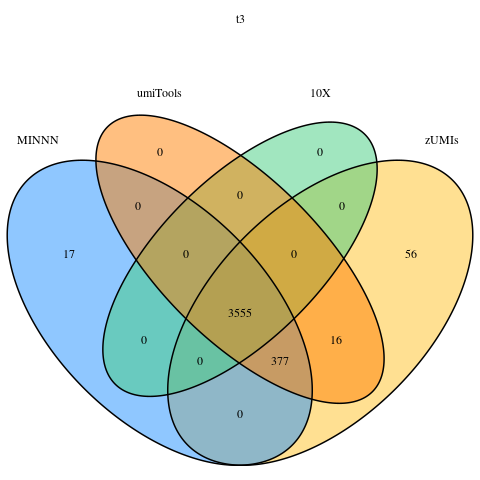

In [16]:
%%R
t3_diagram=venn.diagram(
 x = list(
    "MINNN" = t3_minnn_allBC,
    "zUMIs" = t3_zUMIs_allBC,
    "umiTools" = t3_umiTools_allBC,
    "10X" = t3_10X_allBC        
    ), filename=NULL,output = TRUE,
    fill = c("dodgerblue", "goldenrod1", "darkorange1", "seagreen3"), main="t3")

grid.draw(t3_diagram)

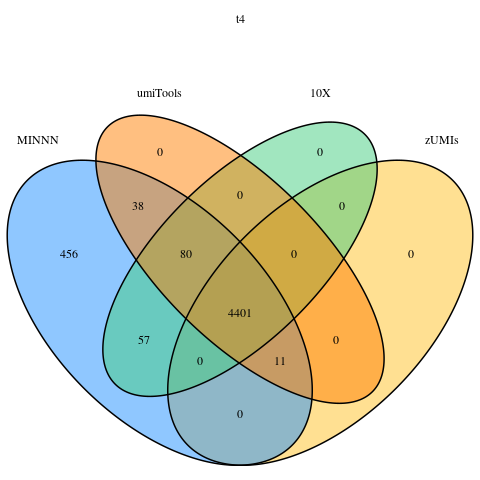

In [92]:
%%R
t4_diagram=venn.diagram(
 x = list(
    "MINNN" = t4_minnn_allBC,
    "zUMIs" = t4_zUMIs_allBC,
    "umiTools" = t4_umiTools_allBC,
    "10X" = t4_10X_allBC        
    ), filename=NULL,output = TRUE,
    fill = c("dodgerblue", "goldenrod1", "darkorange1", "seagreen3"),main="t4")

grid.draw(t4_diagram)

#### all methods looks similar, let s see whatt will be if we compare two different biological replicas t3 and t4

#### does this extra 456 UMIs (found only by MINNN) minor (and so it is only the treshold problem?)

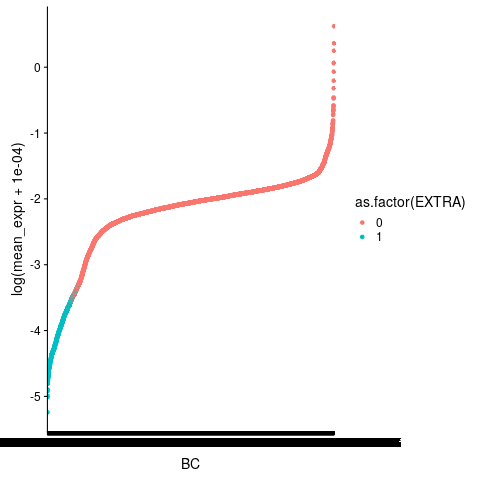

In [130]:
%%R
extraMINNN=t4_minnn_allBC[!t4_minnn_allBC %in% c(as.character(t4_10X_allBC),t4_zUMIs_allBC,t4_umiTools_allBC)]
mean_expr=colMeans(t4_minnn)
t4_minnn_mean_expression_extra=data.frame("BC"=names(mean_expr),"mean_expr"=mean_expr,"EXTRA"=0)
t4_minnn_mean_expression_extra[t4_minnn_mean_expression_extra$BC %in% extraMINNN,]$EXTRA=1
t4_minnn_mean_expression_extra=t4_minnn_mean_expression_extra[order(t4_minnn_mean_expression_extra$mean_expr),]
t4_minnn_mean_expression_extra$BC=factor(t4_minnn_mean_expression_extra$BC,
                            levels = t4_minnn_mean_expression_extra$BC[order(t4_minnn_mean_expression_extra$mean_expr)])
ggplot(t4_minnn_mean_expression_extra,aes(x=BC,y=log(mean_expr+0.0001),
                                          color=as.factor(EXTRA)))+geom_point()

#### so, just a treshold problem...

#### compare UMI from different biological replicas

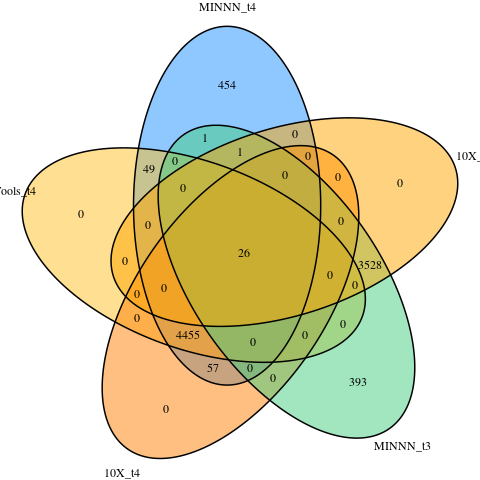

In [13]:
%%R
t3_t4_diagram=venn.diagram(
 x = list(
    "MINNN_t4" = t4_minnn_allBC,
   
    "umiTools_t4" = t4_umiTools_allBC,
    "10X_t4" = t4_10X_allBC,
    "MINNN_t3" = t3_minnn_allBC,
    
    "10X_t3" = t3_10X_allBC
    ), filename=NULL,output = TRUE,
    fill = c("dodgerblue", "goldenrod1", "darkorange1", "seagreen3",
            "orange"))

grid.draw(t3_t4_diagram)

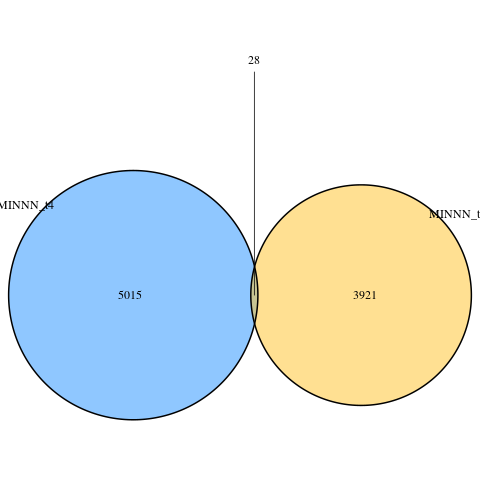

In [14]:
%%R
t3_t4_diagram=venn.diagram(
 x = list(
    "MINNN_t4" = t4_minnn_allBC,
   
    
    "MINNN_t3" = t3_minnn_allBC
    ), filename=NULL,output = TRUE,
    fill = c("dodgerblue", "goldenrod1"))

grid.draw(t3_t4_diagram)

## Corelation of mean expression in cells between methods

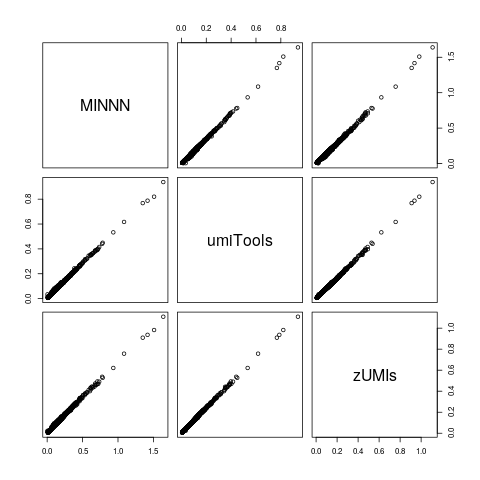

In [153]:
%%R
#FOR EACH METHOD FIND MEAN GENE EXPRESSION IN EACH CELL
mean_expr=colMeans(t3_minnn)
t3_minnn_mean_expression=data.frame("BC"=names(mean_expr),"MINNN"=mean_expr)

mean_expr=colMeans(t3_umiTools_spread)
t3_umiTools_mean_expression=data.frame("BC"=names(mean_expr),"umiTools"=mean_expr)

mean_expr=colMeans(t3_zUMIs$umicount$exon$all)
t3_zUMIs_mean_expression=data.frame("BC"=names(mean_expr),"zUMIs"=mean_expr)

#COMBINE DATA INTO SINGLE DATA FRAME
mean_expression=merge(t3_minnn_mean_expression,t3_umiTools_mean_expression,by="BC")
mean_expression=merge(mean_expression,t3_zUMIs_mean_expression,by="BC")

pairs(mean_expression[2:4]) #compare only shared cells

mean expressions are perfectly correlated, while expression predicted by MINNN is higher

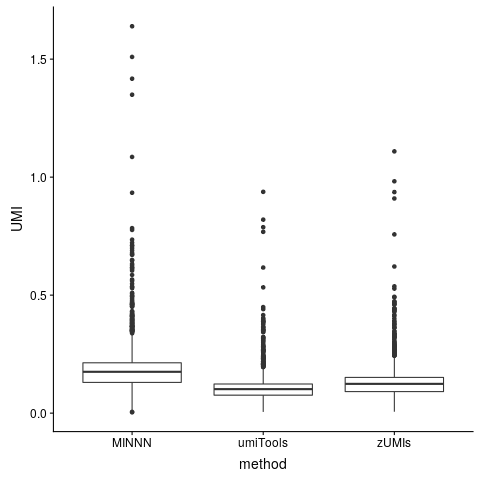

In [161]:
%%R
ggplot(gather(mean_expression[2:4],key="method", value="UMI"), aes(x=method,y=UMI)) +geom_boxplot()

In [47]:
workingDirectory="/home/taumata/shared-with-me/minnn_analysis/results/singlecell"

geneCELLumi={}

t3MINNNfile=open(str(workingDirectory)+"/t3_minnn/allCells.fastq_map_Aligned.sortedByCoord.out.bam.featureCounts","r")
for line in t3MINNNfile:
    temp=line.strip().split("\t")
    if int(temp[2])==1:
        gene=temp[-1]
        cell=temp[0].split(":")[-1]
        umi=temp[0].split("~")[1]
        if gene not in geneCELLumi:
            geneCELLumi[gene]={}
        if cell not in geneCELLumi[gene]:
            geneCELLumi[gene][cell]=[]
        geneCELLumi[gene][cell].append(umi)
t3MINNNfile.close()

In [48]:
len(geneCELLumi)

23828

In [ ]:
%%R
#FOR EACH METHOD FIND MEAN GENE EXPRESSION IN EACH CELL
mean_expr=colMeans(t3_minnn)
t3_minnn_mean_expression=data.frame("BC"=names(mean_expr),"MINNN"=mean_expr)

mean_expr=colMeans(t3_umiTools_spread)
t3_umiTools_mean_expression=data.frame("BC"=names(mean_expr),"umiTools"=mean_expr)

mean_expr=colMeans(t3_zUMIs$umicount$exon$all)
t3_zUMIs_mean_expression=data.frame("BC"=names(mean_expr),"zUMIs"=mean_expr)

#COMBINE DATA INTO SINGLE DATA FRAME
mean_expression=merge(t3_minnn_mean_expression,t3_umiTools_mean_expression,by="BC")
mean_expression=merge(mean_expression,t3_zUMIs_mean_expression,by="BC")

pairs(mean_expression[2:4]) #compare only shared cells

In [52]:
%%R
head(colSums(t3_minnn))

CCTTTCTAGGCGTACA ACACCCTTCTACGAGT CATCAAGTCACCACCT GTTTCTAGTCCGAATT 
            3864             3550             3716             1361 
CCGGTAGAGATAGCAT CGTTCTGTCTTCGGTC 
            4993             5182 


In [ ]:
%%R
head(t4_zUMIs_seurat

Number of not-zero genes-cells pairs

In [194]:
%%R
print(sum(t3_zUMIs$umicount$exon$all!=0)/(dim(t3_zUMIs$umicount$exon$all)[1]*dim(t3_zUMIs$umicount$exon$all)[2]))
print(sum(t3_umiTools_spread!=0)/(dim(t3_umiTools_spread)[1]*dim(t3_umiTools_spread)[2]))
print(sum(t3_minnn!=0)/(dim(t3_minnn)[1]*dim(t3_minnn)[2]))

[1] 0.03910579
[1] 0.03424811
[1] 0.03397809


### And compare mean expression of genes for whole data set

In [18]:
%%R
#this part taken from https://www.r-bloggers.com/five-ways-to-visualize-your-pairwise-comparisons/
panel.cor <- function(x, y, digits=2, prefix="", cex.cor) 
{
    usr <- par("usr"); on.exit(par(usr)) 
    par(usr = c(0, 1, 0, 1)) 
    r <- abs(cor(x, y,method="spearman")) 
    txt <- format(c(r, 0.123456789), digits=digits)[1] 
    txt <- paste(prefix, txt, sep="") 
    if(missing(cex.cor)) cex <- 0.8/strwidth(txt) 
 
    test <- cor.test(x,y) 
    # borrowed from printCoefmat
    Signif <- symnum(test$p.value, corr = FALSE, na = FALSE, 
                  cutpoints = c(0, 0.001, 0.01, 0.05, 0.1, 1),
                  symbols = c("***", "**", "*", ".", " ")) 
 
    text(0.5, 0.5, txt, cex = cex * r) 
    text(.8, .8, Signif, cex=cex, col=2) 
}

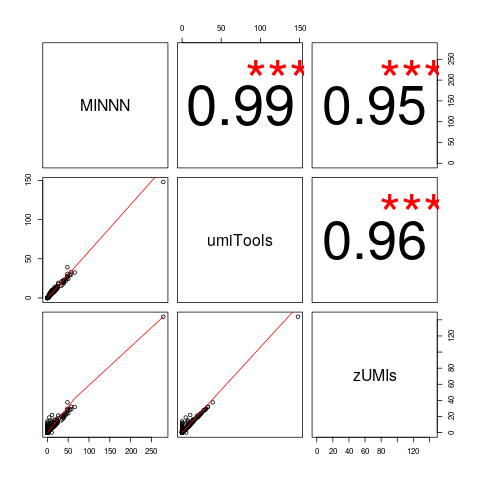

In [211]:
%%R
#FOR EACH METHOD FIND MEAN GENE EXPRESSION FOR EACH GENE
mean_expr=rowMeans(t3_minnn)
t3_minnn_mean_expression=data.frame("gene"=names(mean_expr),"MINNN"=mean_expr)

mean_expr=rowMeans(t3_umiTools_spread)
t3_umiTools_mean_expression=data.frame("gene"=names(mean_expr),"umiTools"=mean_expr)

mean_expr=rowMeans(t3_zUMIs$umicount$exon$all)
t3_zUMIs_mean_expression=data.frame("gene"=names(mean_expr),"zUMIs"=mean_expr)

#COMBINE DATA INTO SINGLE DATA FRAME
mean_expression=merge(t3_minnn_mean_expression,t3_umiTools_mean_expression,by="gene")
mean_expression=merge(mean_expression,t3_zUMIs_mean_expression,by="gene")

pairs(mean_expression[2:4], lower.panel=panel.smooth, upper.panel=panel.cor) #compare only shared cells

Tansform x-axis to log

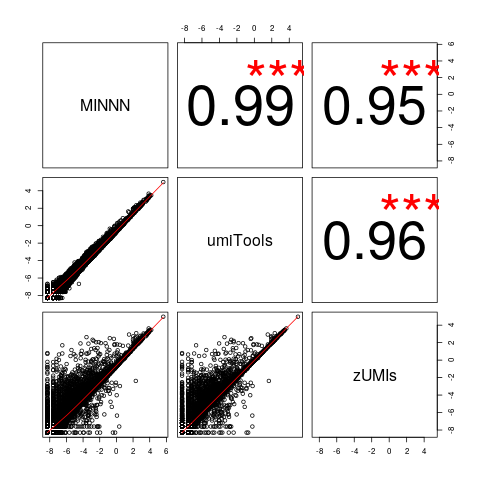

In [212]:
%%R
pairs(log(mean_expression[2:4]), lower.panel=panel.smooth, upper.panel=panel.cor)

### Who is that super expressed outlier?

In [214]:
%%R
mean_expression[mean_expression[2:4] == max(mean_expression[2:4]),]

                 gene    MINNN umiTools    zUMIs
17293 ENSG00000251562 278.5386 147.9417 143.8804


ENSG00000251562 MALAT1 Metastasis associated lung adenocarcinoma transcript 1

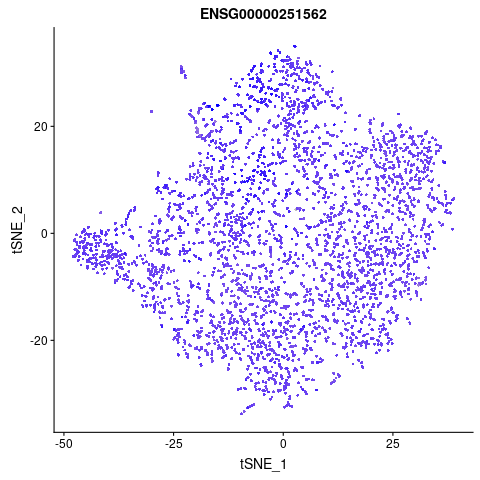

In [215]:
%%R
#figure taken from "future" looks like all cells express ENSG00000251562
FeaturePlot(object = t3_minnn_seurat, features.plot = c("ENSG00000251562"), cols.use = c("grey", "blue"), 
    reduction.use = "tsne")

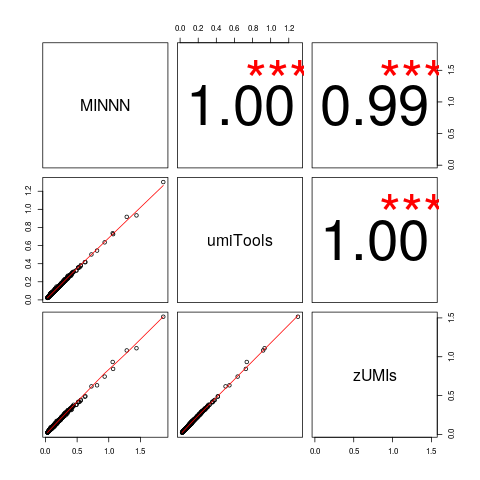

In [23]:
%%R
#FOR EACH METHOD FIND MEAN GENE EXPRESSION IN EACH CELL
mean_expr=colMeans(t4_minnn)
t4_minnn_mean_expression=data.frame("BC"=names(mean_expr),"MINNN"=mean_expr)

mean_expr=colMeans(t4_umiTools_spread)
t4_umiTools_mean_expression=data.frame("BC"=names(mean_expr),"umiTools"=mean_expr)

mean_expr=colMeans(t4_zUMIs$umicount$exon$all)
t4_zUMIs_mean_expression=data.frame("BC"=names(mean_expr),"zUMIs"=mean_expr)

#COMBINE DATA INTO SINGLE DATA FRAME
mean_expression=merge(t4_minnn_mean_expression,t4_umiTools_mean_expression,by="BC")
mean_expression=merge(mean_expression,t4_zUMIs_mean_expression,by="BC")

pairs(mean_expression[2:4], lower.panel=panel.smooth, upper.panel=panel.cor) #compare only shared cells

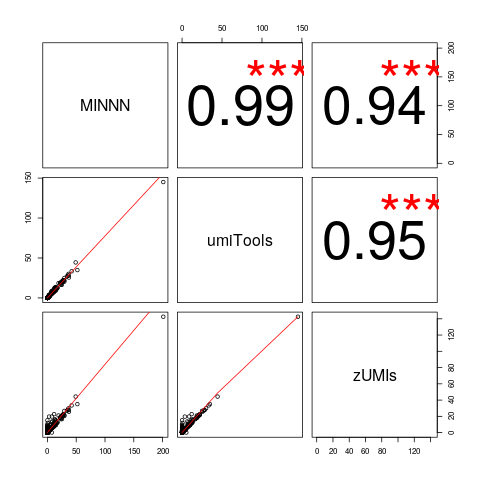

In [24]:
%%R
#FOR EACH METHOD FIND MEAN GENE EXPRESSION FOR EACH GENE
mean_expr=rowMeans(t4_minnn)
t4_minnn_mean_expression=data.frame("gene"=names(mean_expr),"MINNN"=mean_expr)

mean_expr=rowMeans(t4_umiTools_spread)
t4_umiTools_mean_expression=data.frame("gene"=names(mean_expr),"umiTools"=mean_expr)

mean_expr=rowMeans(t4_zUMIs$umicount$exon$all)
t4_zUMIs_mean_expression=data.frame("gene"=names(mean_expr),"zUMIs"=mean_expr)

#COMBINE DATA INTO SINGLE DATA FRAME
mean_expression=merge(t4_minnn_mean_expression,t4_umiTools_mean_expression,by="gene")
mean_expression=merge(mean_expression,t4_zUMIs_mean_expression,by="gene")

pairs(mean_expression[2:4], lower.panel=panel.smooth, upper.panel=panel.cor) #compare only shared cells

In [25]:
%%R
mean_expression[mean_expression[2:4] == max(mean_expression[2:4]),]

                 gene    MINNN umiTools    zUMIs
17002 ENSG00000251562 201.2124 145.0331 142.5585


ENSG00000251562 MALAT1 Metastasis associated lung adenocarcinoma transcript 1

And genes from two replicas

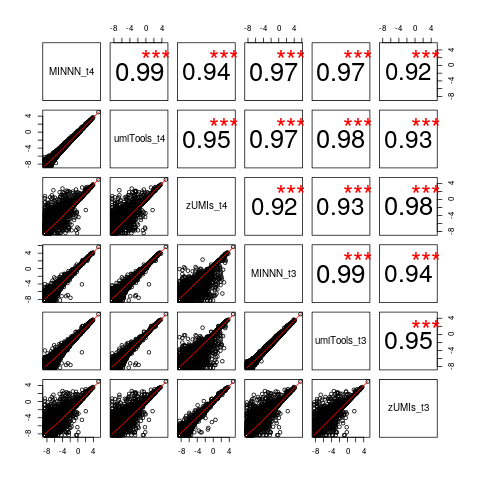

In [28]:
%%R
#FOR EACH METHOD FIND MEAN GENE EXPRESSION FOR EACH GENE
mean_expr=rowMeans(t4_minnn)
t4_minnn_mean_expression=data.frame("gene"=names(mean_expr),"MINNN_t4"=mean_expr)

mean_expr=rowMeans(t3_minnn)
t3_minnn_mean_expression=data.frame("gene"=names(mean_expr),"MINNN_t3"=mean_expr)

mean_expr=rowMeans(t4_zUMIs$umicount$exon$all)
t4_zUMIs_mean_expression=data.frame("gene"=names(mean_expr),"zUMIs_t4"=mean_expr)

mean_expr=rowMeans(t3_zUMIs$umicount$exon$all)
t3_zUMIs_mean_expression=data.frame("gene"=names(mean_expr),"zUMIs_t3"=mean_expr)

mean_expr=rowMeans(t4_umiTools_spread)
t4_umiTools_mean_expression=data.frame("gene"=names(mean_expr),"umiTools_t4"=mean_expr)

mean_expr=rowMeans(t3_umiTools_spread)
t3_umiTools_mean_expression=data.frame("gene"=names(mean_expr),"umiTools_t3"=mean_expr)



#COMBINE DATA INTO SINGLE DATA FRAME
mean_expression=merge(t4_minnn_mean_expression,t4_umiTools_mean_expression,by="gene")
mean_expression=merge(mean_expression,t4_zUMIs_mean_expression,by="gene")
mean_expression=merge(mean_expression,t3_minnn_mean_expression,by="gene")
mean_expression=merge(mean_expression,t3_umiTools_mean_expression,by="gene")
mean_expression=merge(mean_expression,t3_zUMIs_mean_expression,by="gene")




pairs(log(mean_expression[2:7]), lower.panel=panel.smooth, upper.panel=panel.cor) #compare only shared cells

In [40]:
%%R
head(t3_minnn)

                CCTTTCTAGGCGTACA ACACCCTTCTACGAGT CATCAAGTCACCACCT
ENSG00000255188                0                0                0
ENSG00000189171                0                0                0
ENSG00000267312                0                0                0
ENSG00000223756                0                0                0
ENSG00000147138                0                0                2
ENSG00000139537                0                1                0
                GTTTCTAGTCCGAATT CCGGTAGAGATAGCAT CGTTCTGTCTTCGGTC
ENSG00000255188                0                0                0
ENSG00000189171                0                0                0
ENSG00000267312                0                0                0
ENSG00000223756                0                0                0
ENSG00000147138                0                0                0
ENSG00000139537                0                0                0
                ACGCCGAAGCTACCTA TCGGTAATCCGGCACA CTTAACTCATGG

## tSNE of combined (as replicas) t_3 and t_4
1) using preprocessed data from 10x genomics

Read the 8093 x 50 data matrix successfully!
Using no_dims = 2, perplexity = 30.000000, and theta = 0.500000
Computing input similarities...
Normalizing input...
Building tree...
 - point 0 of 8093
Done in 13.12 seconds (sparsity = 0.016106)!
Learning embedding...
Iteration 50: error is 93.948563 (50 iterations in 8.01 seconds)
Iteration 100: error is 84.089970 (50 iterations in 7.41 seconds)
Iteration 150: error is 83.052110 (50 iterations in 6.85 seconds)
Iteration 200: error is 83.020907 (50 iterations in 7.15 seconds)
Iteration 250: error is 83.022640 (50 iterations in 7.29 seconds)
Iteration 300: error is 2.944597 (50 iterations in 6.67 seconds)
Iteration 350: error is 2.658926 (50 iterations in 6.59 seconds)
Iteration 400: error is 2.511292 (50 iterations in 6.67 seconds)
Iteration 450: error is 2.415695 (50 iterations in 6.70 seconds)
Iteration 500: error is 2.346835 (50 iterations in 6.82 seconds)
Fitting performed in 70.16 seconds.


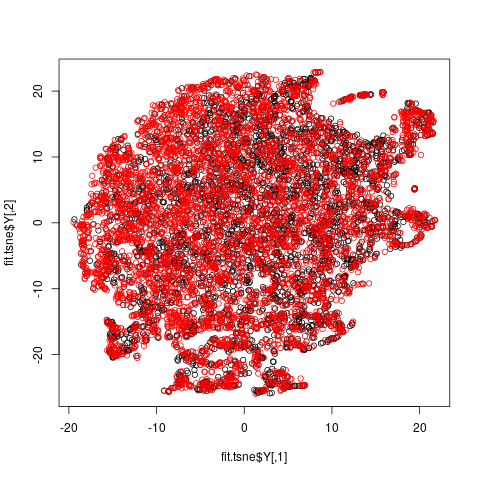

In [64]:
%%R
t3=read.table("/home/taumata/shared-with-me/minnn_analysis/results/singlecell/t3_10x_gene_table",header = T,
              sep = "\t")
t4=read.table("/home/taumata/shared-with-me/minnn_analysis/results/singlecell/t4_10x_gene_table",header = T,
              sep = "\t")


tags=c(rep("3",dim(t3)[2]),rep("4",dim(t4)[2]))
t_merge=merge(t3,t4,by=0)
t_merge[,"Row.names"]
rownames(t_merge)=t_merge$Row.names
t_merge=t_merge[,colnames(t_merge) != "Row.names"]


fit.tsne <- Rtsne(t(t_merge), dims=2,
                  check_duplicates = FALSE,
                  perplexity=30, verbose=TRUE, max_iter = 500)
plot(fit.tsne$Y, col = as.factor(tags))

2) from zUMIs

read data and keep all genes expressed in >= 3 cells and all cells with at least 200 detected genes (as in Seurat 

In [37]:
%%R
folder="/home/taumata/shared-with-me/minnn_analysis/results/singlecell/"

t4_zUMIs=readRDS(paste(folder,"zUMIs_t4/zUMIs_output/expression/t4_zUMIs.dgecounts.rds",sep=""))
t3_zUMIs=readRDS(paste(folder,"zUMIs_t3/zUMIs_output/expression/t3_zUMIs.dgecounts.rds",sep=""))

In [38]:
%%R
t4_zUMIs_seurat <- CreateSeuratObject(raw.data = t4_zUMIs$umicount$exon$all, min.cells = 3, min.genes = 200, 
    project = "t4_zUMIs")
t3_zUMIs_seurat <- CreateSeuratObject(raw.data = t3_zUMIs$umicount$exon$all, min.cells = 3, min.genes = 200, 
    project = "t3_zUMIs")

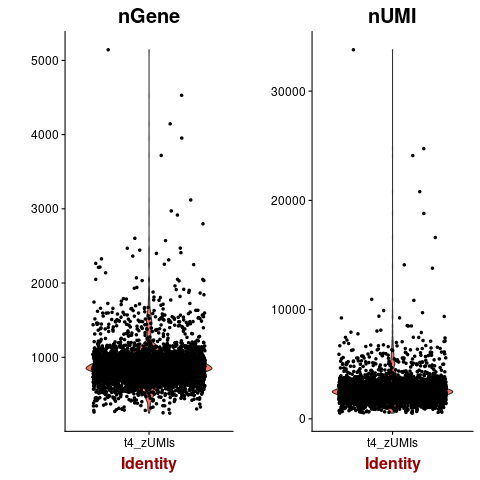

In [116]:
%%R
VlnPlot(object = t4_zUMIs_seurat, features.plot = c("nGene", "nUMI"), nCol = 2)

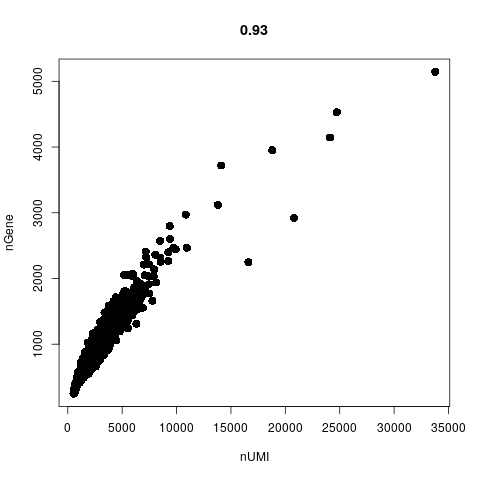

In [117]:
%%R
GenePlot(object = t4_zUMIs_seurat, gene1 = "nUMI", gene2 = "nGene")

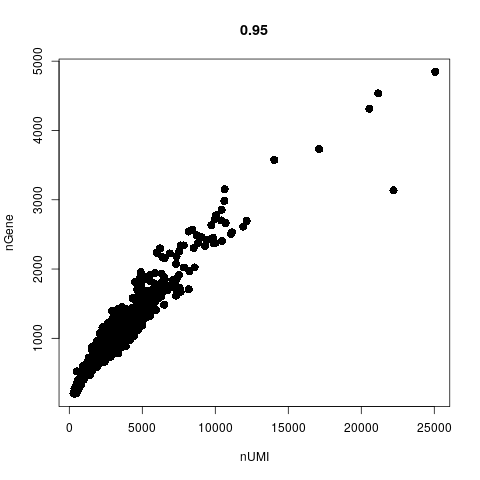

In [39]:
%%R
GenePlot(object = t3_zUMIs_seurat, gene1 = "nUMI", gene2 = "nGene")

/home/taumata/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Performing log-normalization

  warnings.warn(x, RRuntimeWarning)
/home/taumata/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 0%   10   20   30   40   50   60   70   80   90   100%

  warnings.warn(x, RRuntimeWarning)
/home/taumata/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: [----|----|----|----|----|----|----|----|----|----|

  warnings.warn(x, RRuntimeWarning)
/home/taumata/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: *
  warnings.warn(x, RRuntimeWarning)
/home/taumata/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: |

  warnings.warn(x, RRuntimeWarning)
/home/taumata/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Calculating gene means
  warnings.warn(x, RRuntimeWarning)
/home

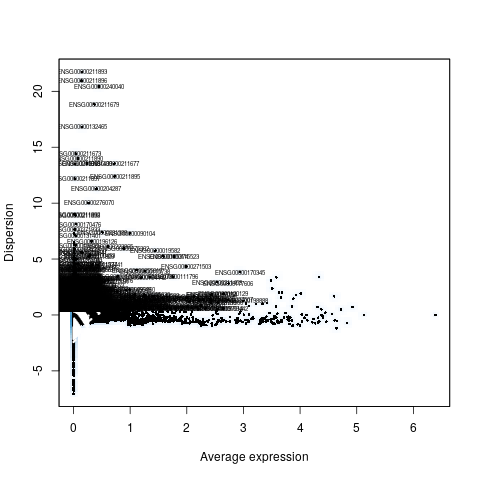

In [53]:
%%R
t4_zUMIs_seurat <- FilterCells(object = t4_zUMIs_seurat, subset.names = c("nGene"), 
    low.thresholds = c(200), high.thresholds = c(3000))
t4_zUMIs_seurat <- NormalizeData(object = t4_zUMIs_seurat, normalization.method = "LogNormalize", 
    scale.factor = 10000)
t4_zUMIs_seurat <- FindVariableGenes(object = t4_zUMIs_seurat, mean.function = ExpMean, dispersion.function = LogVMR, 
    x.low.cutoff = 0.0125, x.high.cutoff = 3, y.cutoff = 0.5)

In [119]:
%%R
length(x = t4_zUMIs_seurat@var.genes)

[1] 2159



Time Elapsed:  51.9921636581421 secs[1] "PC1"
[1] "ENSG00000227507" "ENSG00000126353" "ENSG00000119801" "ENSG00000188404"
[5] "ENSG00000130844"
[1] ""
[1] "ENSG00000105374" "ENSG00000115523" "ENSG00000271503" "ENSG00000100450"
[5] "ENSG00000077984"
[1] ""
[1] ""
[1] "PC2"
[1] "ENSG00000206652" "ENSG00000179144" "ENSG00000279602" "ENSG00000211459"
[5] "ENSG00000276216"
[1] ""
[1] "ENSG00000128016" "ENSG00000100906" "ENSG00000102760" "ENSG00000119801"
[5] "ENSG00000110848"
[1] ""
[1] ""
[1] "PC3"
[1] "ENSG00000172116" "ENSG00000255819" "ENSG00000153563" "ENSG00000100450"
[5] "ENSG00000256039"
[1] ""
[1] "ENSG00000111796" "ENSG00000196154" "ENSG00000160789" "ENSG00000227507"
[5] "ENSG00000213145"
[1] ""
[1] ""
[1] "PC4"
[1] "ENSG00000111796" "ENSG00000171476" "ENSG00000196154" "ENSG00000145220"
[5] "ENSG00000008517"
[1] ""
[1] "ENSG00000204287" "ENSG00000196126" "ENSG00000196735" "ENSG00000237541"
[5] "ENSG00000179344"
[1] ""
[1] ""
[1] "PC5"
[1] "ENSG00000137441" "ENSG00000213145" "ENSG

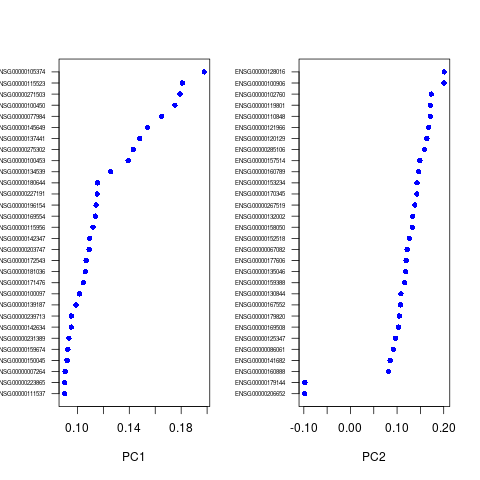

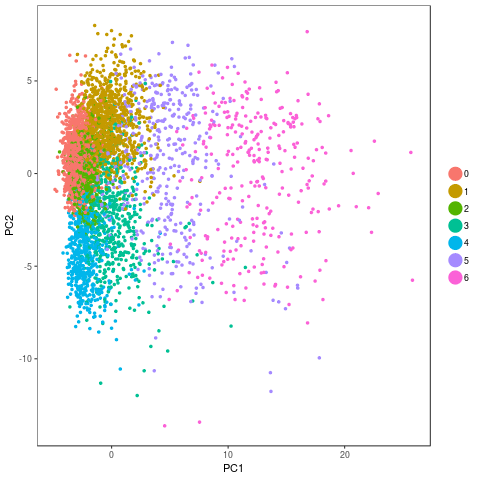

In [146]:
%%R
t4_zUMIs_seurat <- ScaleData(object = t4_zUMIs_seurat, vars.to.regress = c("nUMI"))
t4_zUMIs_seurat <- RunPCA(object = t4_zUMIs_seurat, pc.genes = t4_zUMIs_seurat@var.genes, do.print = TRUE, pcs.print = 1:5, 
    genes.print = 5)
PrintPCA(object = t4_zUMIs_seurat, pcs.print = 1:5, genes.print = 5, use.full = FALSE)
VizPCA(object = t4_zUMIs_seurat, pcs.use = 1:2)
PCAPlot(object = t4_zUMIs_seurat, dim.1 = 1, dim.2 = 2)

In [ ]:
t4_zUMIs_seurat <- JackStraw(object = t4_zUMIs_seurat, num.replicate = 100, display.progress = FALSE)
JackStrawPlot(object = t4_zUMIs_seurat, PCs = 1:12)

In [ ]:
t4_zUMIs_seurat <- FindClusters(object = t4_zUMIs_seurat, reduction.type = "pca", dims.use = 1:10, 
    resolution = 0.6, print.output = 0, save.SNN = TRUE)
PrintFindClustersParams(object = t4_zUMIs_seurat)
t4_zUMIs_seurat <- RunTSNE(object = t4_zUMIs_seurat, dims.use = 1:10, do.fast = TRUE)
TSNEPlot(object = t4_zUMIs_seurat)
t4_zUMIs_seurat.markers <- FindAllMarkers(object = t4_zUMIs_seurat, only.pos = TRUE, min.pct = 0.25, 
    thresh.use = 0.25)
t4_zUMIs_seurat.markers %>% group_by(cluster) %>% top_n(2, avg_logFC)
#FeaturePlot(object = t4_zUMIs_seurat, features.plot = c("MS4A1", "GNLY", "CD3E", "CD14", 
#    "FCER1A", "FCGR3A", "LYZ", "PPBP", "CD8A"), cols.use = c("grey", "blue"), 
#    reduction.use = "tsne")

3) from UMI-tools

In [67]:
%%bash
gunzip -k /home/taumata/shared-with-me/minnn_analysis/results/singlecell/t4_umiTools_umitools_counts.tsv.gz
gunzip -k /home/taumata/shared-with-me/minnn_analysis/results/singlecell/t3_umiTools_umitools_counts.tsv.gz

In [79]:
%%R
library(Seurat)

In [88]:
%%R
t4_umi <- read.csv("/home/taumata/shared-with-me/minnn_analysis/results/singlecell/t4_umiTools_umitools_counts.tsv",
                   sep = "\t", header = TRUE, row.names = 1)


Error in read.table(file = file, header = header, sep = sep, quote = quote,  : 
  duplicate 'row.names' are not allowed


/home/taumata/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Error in read.table(file = file, header = header, sep = sep, quote = quote,  : 
  duplicate 'row.names' are not allowed

  warnings.warn(x, RRuntimeWarning)


In [163]:
%%R
t4_umi_spread=spread(t4_umi,key=cell, value=count, fill=0)
rownames(t4_umi_spread)=t4_umi_spread$gene
t4_umi_spread=t4_umi_spread[,colnames(t4_umi_spread)!="gene"]
head(t4_umi_spread)

                AAACCTGAGTGAAGAG AAACCTGCAAACCTAC AAACCTGCACTGCCAG
ENSG00000000003                0                0                0
ENSG00000000419                0                1                0
ENSG00000000457                0                0                0
ENSG00000000460                0                0                0
ENSG00000000938                0                0                0
ENSG00000000971                0                0                0
                AAACCTGCAGGTGCCT AAACCTGCAGTAACGG AAACCTGGTGCCTGCA
ENSG00000000003                0                0                0
ENSG00000000419                0                0                0
ENSG00000000457                0                0                0
ENSG00000000460                0                0                0
ENSG00000000938                0                0                0
ENSG00000000971                0                0                0
                AAACCTGTCGGCATCG AAACGGGAGAAGGTGA AAACGGGAGACA

In [164]:
%%R
t4_umiTools_seurat <- CreateSeuratObject(raw.data = t4_umi_spread, min.cells = 3, min.genes = 200, 
    project = "t4_umiTools")

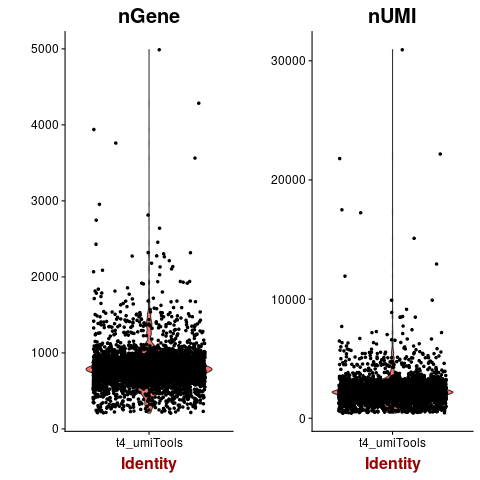

In [165]:
%%R
VlnPlot(object = t4_umiTools_seurat, features.plot = c("nGene", "nUMI"), nCol = 2)

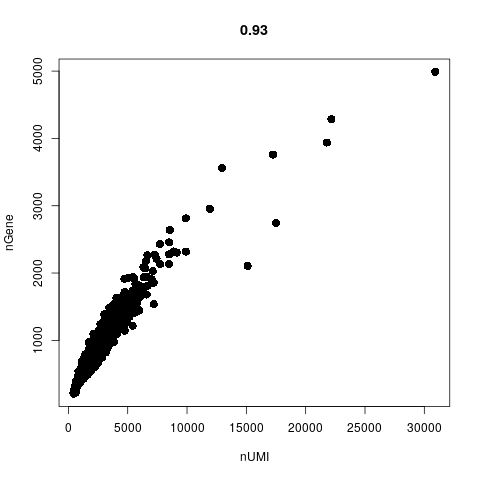

In [181]:
%%R
GenePlot(object = t4_umiTools_seurat, gene1 = "nUMI", gene2 = "nGene")

In [179]:
%%R
dim(t4_umi_spread)

[1] 23766  4530


In [180]:
%%R
sum(t4_umi_spread)

[1] 10431046


4) from minnn

In [54]:
%%R
t3_minnn <- read.csv("/home/taumata/shared-with-me/minnn_analysis/results/singlecell/t3_minnn_gene_assignment",
                   sep = "\t", header = TRUE, row.names = 1)


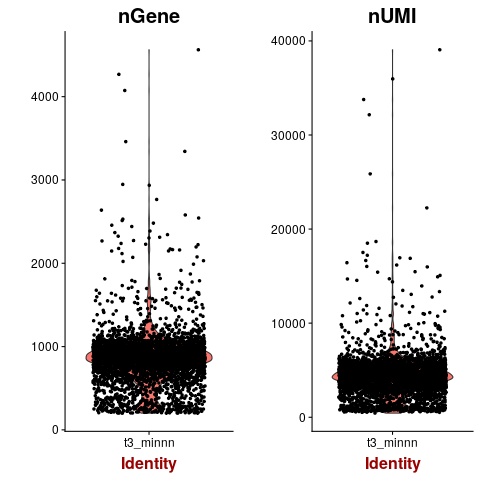

In [55]:
%%R
t3_minnn_seurat <- CreateSeuratObject(raw.data = t3_minnn, min.cells = 3, min.genes = 200, 
    project = "t3_minnn")
VlnPlot(object = t3_minnn_seurat, features.plot = c("nGene", "nUMI"), nCol = 2)

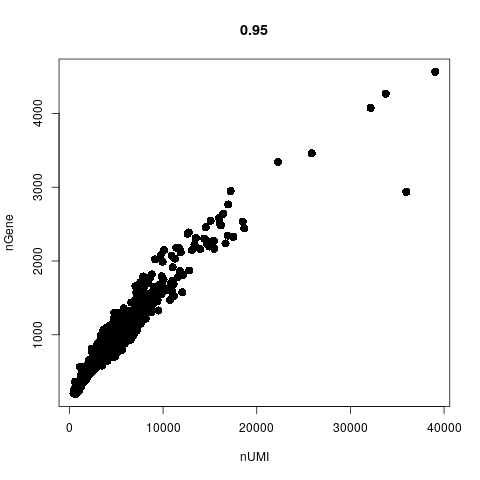

In [56]:
%%R
GenePlot(object = t3_minnn_seurat, gene1 = "nUMI", gene2 = "nGene")

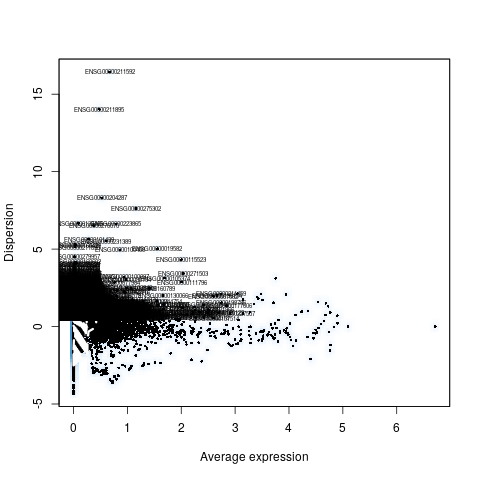

In [57]:
%%R
t3_minnn_seurat <- FilterCells(object = t3_minnn_seurat, subset.names = c("nGene"), 
    low.thresholds = c(200), high.thresholds = c(3000))
t3_minnn_seurat <- NormalizeData(object = t3_minnn_seurat, normalization.method = "LogNormalize", 
    scale.factor = 10000)
t3_minnn_seurat <- FindVariableGenes(object = t3_minnn_seurat, mean.function = ExpMean, dispersion.function = LogVMR, 
    x.low.cutoff = 0.0125, x.high.cutoff = 3, y.cutoff = 0.5)


/home/taumata/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Regressing out: nUMI

  warnings.warn(x, RRuntimeWarning)
  |                                                                            :146: RRuntimeWarning: 
  warnings.warn(x, RRuntimeWarning)
  |                                                                      |   0%:146: RRuntimeWarning: 
  warnings.warn(x, RRuntimeWarning)
  |                                                                      |   1%:146: RRuntimeWarning: 
  warnings.warn(x, RRuntimeWarning)
  |=                                                                     |   1%:146: RRuntimeWarning: 
  warnings.warn(x, RRuntimeWarning)
  |=                                                                     |   2%:146: RRuntimeWarning: 
  warnings.warn(x, RRuntimeWarning)
  |==                                                                    |   2%:146: RRuntimeWarning: 
  warnings.warn(x, RRuntimeWarning)
  |== 

  |==============================                                        |  43%:146: RRuntimeWarning: 
  warnings.warn(x, RRuntimeWarning)
  |===============================                                       |  44%:146: RRuntimeWarning: 
  warnings.warn(x, RRuntimeWarning)
  |===============================                                       |  45%:146: RRuntimeWarning: 
  warnings.warn(x, RRuntimeWarning)
  |================================                                      |  45%:146: RRuntimeWarning: 
  warnings.warn(x, RRuntimeWarning)
  |================================                                      |  46%:146: RRuntimeWarning: 
  warnings.warn(x, RRuntimeWarning)
  |=================================                                     |  47%:146: RRuntimeWarning: 
  warnings.warn(x, RRuntimeWarning)
  |==================================                                    |  48%:146: RRuntimeWarning: 
  warnings.warn(x, RRuntimeWarning)
  |========================

  |================================================================      |  91%:146: RRuntimeWarning: 
  warnings.warn(x, RRuntimeWarning)
  |================================================================      |  92%:146: RRuntimeWarning: 
  warnings.warn(x, RRuntimeWarning)
  |=================================================================     |  92%:146: RRuntimeWarning: 
  warnings.warn(x, RRuntimeWarning)
  |=================================================================     |  93%:146: RRuntimeWarning: 
  warnings.warn(x, RRuntimeWarning)
  |==================================================================    |  94%:146: RRuntimeWarning: 
  warnings.warn(x, RRuntimeWarning)
  |==================================================================    |  95%:146: RRuntimeWarning: 
  warnings.warn(x, RRuntimeWarning)
  |===================================================================   |  96%:146: RRuntimeWarning: 
  warnings.warn(x, RRuntimeWarning)
  |========================


Time Elapsed:  36.2256009578705 secs[1] "PC1"
[1] "ENSG00000227507" "ENSG00000119801" "ENSG00000114861" "ENSG00000237943"
[5] "ENSG00000164300"
[1] ""
[1] "ENSG00000105374" "ENSG00000115523" "ENSG00000100450" "ENSG00000271503"
[5] "ENSG00000077984"
[1] ""
[1] ""
[1] "PC2"
[1] "ENSG00000179144" "ENSG00000108848" "ENSG00000241666" "ENSG00000211459"
[5] "ENSG00000244879"
[1] ""
[1] "ENSG00000128016" "ENSG00000100906" "ENSG00000102760" "ENSG00000119801"
[5] "ENSG00000120129"
[1] ""
[1] ""
[1] "PC3"
[1] "ENSG00000172116" "ENSG00000100450" "ENSG00000137441" "ENSG00000153563"
[5] "ENSG00000256039"
[1] ""
[1] "ENSG00000160789" "ENSG00000196154" "ENSG00000111796" "ENSG00000163191"
[5] "ENSG00000067082"
[1] ""
[1] ""
[1] "PC4"
[1] "ENSG00000204287" "ENSG00000229391" "ENSG00000196126" "ENSG00000101439"
[5] "ENSG00000196735"
[1] ""
[1] "ENSG00000008517" "ENSG00000111796" "ENSG00000227507" "ENSG00000196154"
[5] "ENSG00000179144"
[1] ""
[1] ""
[1] "PC5"
[1] "ENSG00000119801" "ENSG00000090104" "ENSG

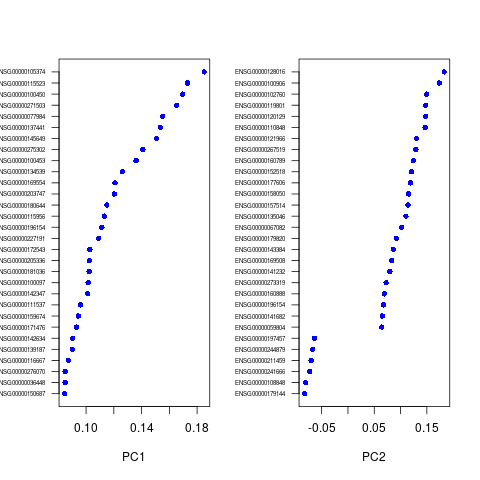

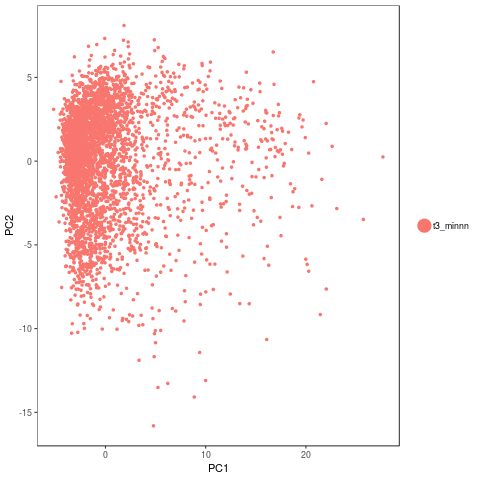

In [58]:
%%R
t3_minnn_seurat <- ScaleData(object = t3_minnn_seurat, vars.to.regress = c("nUMI"))
t3_minnn_seurat <- RunPCA(object = t3_minnn_seurat, pc.genes = t3_minnn_seurat@var.genes, do.print = TRUE, pcs.print = 1:5, 
    genes.print = 5)
PrintPCA(object = t3_minnn_seurat, pcs.print = 1:5, genes.print = 5, use.full = FALSE)
VizPCA(object = t3_minnn_seurat, pcs.use = 1:2)
PCAPlot(object = t3_minnn_seurat, dim.1 = 1, dim.2 = 2)

An object of class seurat in project t3_minnn 
 17802 genes across 3737 samples.


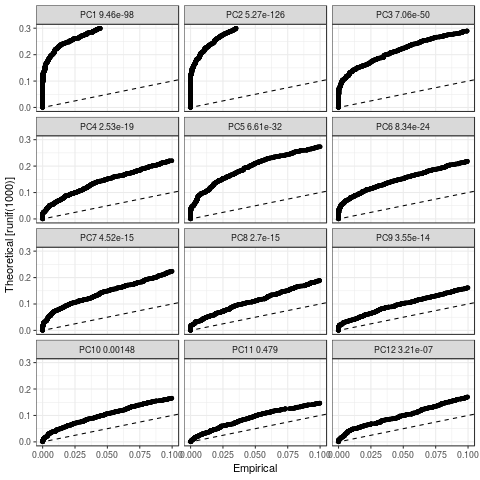

In [59]:
%%R
t3_minnn_seurat <- JackStraw(object = t3_minnn_seurat, num.replicate = 100, display.progress = FALSE)
JackStrawPlot(object = t3_minnn_seurat, PCs = 1:12)

Parameters used in latest FindClusters calculation run on: 2019-01-17 17:47:02
Resolution: 0.6
-----------------------------------------------------------------------------
Modularity Function    Algorithm         n.start         n.iter
     1                   1                 100             10
-----------------------------------------------------------------------------
Reduction used          k.param          prune.SNN
     pca                 30                0.0667
-----------------------------------------------------------------------------
Dims used in calculation
1 2 3 4 5 6 7 8 9 10

   |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed = 05s
   |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed = 04s
   |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed = 10s
   |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed = 13s
   |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed = 04s
   |++++++++++++++++++

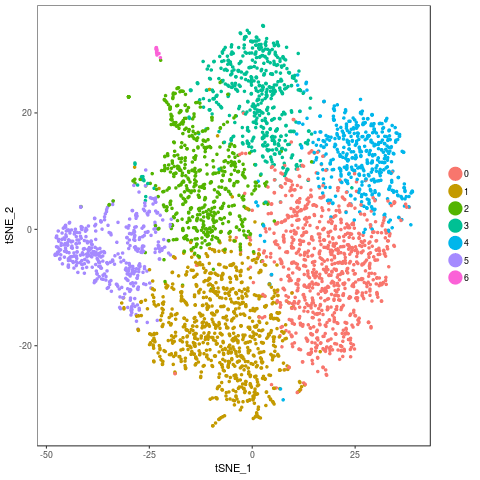

In [60]:
%%R
t3_minnn_seurat <- FindClusters(object = t3_minnn_seurat, reduction.type = "pca", dims.use = 1:10, 
    resolution = 0.6, print.output = 0, save.SNN = TRUE)
PrintFindClustersParams(object = t3_minnn_seurat)
t3_minnn_seurat <- RunTSNE(object = t3_minnn_seurat, dims.use = 1:10, do.fast = TRUE)
TSNEPlot(object = t3_minnn_seurat)
t3_minnn_seurat.markers <- FindAllMarkers(object = t3_minnn_seurat, only.pos = TRUE, min.pct = 0.25, 
    thresh.use = 0.25)
t3_minnn_seurat.markers %>% group_by(cluster) %>% top_n(2, avg_logFC)

In [ ]:
#       p_val avg_logFC pct.1 pct.2 p_val_adj cluster gene           
#        <dbl>     <dbl> <dbl> <dbl>     <dbl> <fct>   <chr>          
#  1 1.38e-99     0.693 0.898 0.606 2.45e-95 0       ENSG00000119801	ENSG00000119801	YPEL5	yippee like 5 [Source:HGNC Symbol;Acc:HGNC:18329]
#  2 5.72e-49     0.653 0.542 0.293 1.02e-44 0       ENSG00000169508	ENSG00000169508	GPR183	G protein-coupled receptor 183 [Source:HGNC Symbol;Acc:HGNC:3128]
#  3 2.75e-231     1.68  0.686 0.156 4.90e-227 1       ENSG00000160789	ENSG00000160789	LMNA	lamin A/C [Source:HGNC Symbol;Acc:HGNC:6636]
#  4 3.54e-108     0.854 0.87  0.551 6.30e-104 1       ENSG00000135046	ENSG00000135046	ANXA1	annexin A1 [Source:HGNC Symbol;Acc:HGNC:533]
#  5 4.79e-77     0.989 0.904 0.783 8.53e-73 2       ENSG00000211459	ENSG00000211459	MT-RNR1	mitochondrially encoded 12S RNA [Source:HGNC Symbol;Acc:HGNC:7470]
#  6 7.75e-4     0.912 0.457 0.411 1.00e+0 2       ENSG00000019582	ENSG00000019582	CD74	CD74 molecule [Source:HGNC Symbol;Acc:HGNC:1697]
#  7 1.22e-19     0.749 0.37  0.206 2.18e-15 3       ENSG00000108848	ENSG00000108848	LUC7L3	LUC7 like 3 pre-mRNA splicing factor [Source:HGNC Symbol;Acc:HGNC:24309]
#  8 6.11e-18     0.772 0.446 0.282 1.09e-13 3       ENSG00000244879	ENSG00000244879	GABPB1-AS1	GABPB1 antisense RNA 1 [Source:HGNC Symbol;Acc:HGNC:44157]
#  9 3.99e-228     1.27  0.604 0.063 7.10e-224 4       ENSG00000256039	ENSG00000256039	LINC02446	long intergenic non-protein coding RNA 2446 [Source:HGNC Symbol;Acc:HGNC:53378]
# 10 1.30e-201     1.17  0.742 0.129 2.31e-197 4       ENSG00000172116	ENSG00000172116	CD8B	CD8b molecule [Source:HGNC Symbol;Acc:HGNC:1707]
# 11 0.            3.16  0.902 0.068 0.        5       ENSG00000105374	ENSG00000105374	NKG7	natural killer cell granule protein 7 [Source:HGNC Symbol;Acc:HGNC:7830]
# 12 0.            3.10  0.779 0.06  0.        5       ENSG00000115523	ENSG00000115523	GNLY	granulysin [Source:HGNC Symbol;Acc:HGNC:4414]
# 13 6.45e-124     2.08  0.5   0.004 1.15e-119 6       ENSG00000211899	ENSG00000211899	IGHM	immunoglobulin heavy constant mu [Source:HGNC Symbol;Acc:HGNC:5541]
# 14 5.98e-73     2.07  1     0.038 1.07e- 68 6       ENSG00000124766	ENSG00000124766	SOX4	SRY-box 4 [Source:HGNC Symbol;Acc:HGNC:11200]

Do cells express CD8, CD4, [CD3], TRAC and TRBC?

In [ ]:
# CD8A
# ENSG00000153563
# CD8B
# ENSG00000172116
# CD8B2
# ENSG00000254126
# CD4
# ENSG00000010610
# TRAC
# ENSG00000277734
# TRBC1
# ENSG00000211751
# TRBC2
# ENSG00000276849

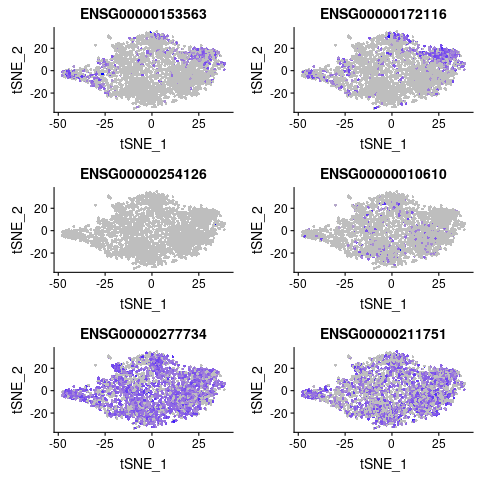

In [63]:
%%R
FeaturePlot(object = t3_minnn_seurat, features.plot = c("ENSG00000153563", "ENSG00000172116", "ENSG00000254126", "ENSG00000010610", 
    "ENSG00000277734", "ENSG00000211751"), cols.use = c("grey", "blue"), 
    reduction.use = "tsne")

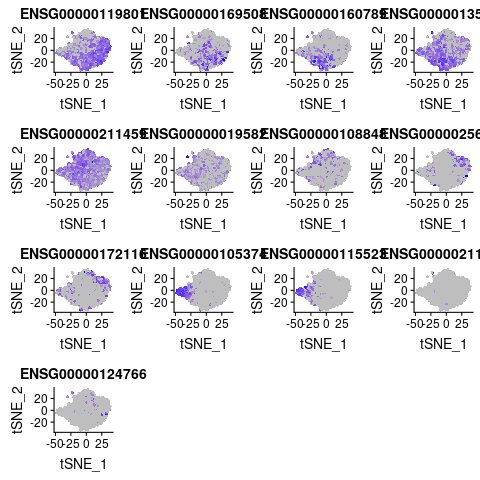

In [61]:
%%R
FeaturePlot(object = t3_minnn_seurat, features.plot = c("ENSG00000119801", "ENSG00000169508", "ENSG00000160789",
                                             "ENSG00000135046", "ENSG00000211459", "ENSG00000019582",
    "ENSG00000108848", "ENSG00000256039", "ENSG00000172116","ENSG00000105374","ENSG00000115523",
                                             "ENSG00000211899", "ENSG00000124766"), cols.use = c("grey", "blue"), 
    reduction.use = "tsne")

In [64]:
%%R
t3_minnn_seurat.markers

                         p_val avg_logFC pct.1 pct.2     p_val_adj cluster
ENSG00000119801   1.377088e-99 0.6932332 0.898 0.606  2.451492e-95       0
ENSG00000110700   7.499917e-97 0.3578451 0.997 0.930  1.335135e-92       0
ENSG00000137154   7.412473e-80 0.2753106 0.999 0.959  1.319568e-75       0
ENSG00000122026   4.225769e-75 0.2846950 0.995 0.943  7.522715e-71       0
ENSG00000145425   8.858467e-72 0.2857400 0.992 0.939  1.576984e-67       0
ENSG00000146278   4.414870e-63 0.5033384 0.897 0.692  7.859352e-59       0
ENSG00000163682   2.758148e-59 0.2768931 0.989 0.928  4.910056e-55       0
ENSG00000182899   8.191540e-58 0.2537867 0.992 0.945  1.458258e-53       0
ENSG00000070756   1.276496e-56 0.3877925 0.950 0.818  2.272418e-52       0
ENSG00000169508   5.722774e-49 0.6534334 0.542 0.293  1.018768e-44       0
ENSG00000127528   5.887309e-49 0.4410745 0.871 0.670  1.048059e-44       0
ENSG00000186468   7.794061e-46 0.2540503 0.989 0.923  1.387499e-41       0
ENSG00000171223   5.88290

CD8A
ENSG00000153563
CD8B
ENSG00000172116
CD8B2
ENSG00000254126
CD4
ENSG00000010610
TRAC
ENSG00000277734
TRBC1
ENSG00000211751
TRBC2
ENSG00000276849

Cluster ID	Markers	Cell Type	ENSEMBL
0	IL7R	CD4 T cells	ENSG00000168685
1	CD14, LYZ	CD14+ Monocytes	ENSG00000170458,ENSG00000090382
2	MS4A1	B cells	ENSG00000156738
3	CD8A	CD8 T cells	ENSG00000153563
4	FCGR3A, MS4A7	FCGR3A+ Monocytes	ENSG00000203747,ENSG00000166927
5	GNLY, NKG7	NK cells	ENSG00000115523,ENSG00000105374
6	FCER1A, CST3	Dendritic Cells	ENSG00000179639,ENSG00000101439
7	PPBP	Megakaryocytes	ENSG00000163736

# Downlad data and other preparing for single-cell TCR

In [ ]:
%%bash
#------Go to work folder------
cd /home/taumata/shared-with-me/minnn_analysis/raw_data/singlecell

#-----download data-----
#TCR SAMPLE
wget http://cf.10xgenomics.com/samples/cell-vdj/3.0.0/vdj_v1_hs_pbmc2_t/vdj_v1_hs_pbmc2_t_fastqs.tar
#5'GENE EXPRESSION SAMPLE
wget http://s3-us-west-2.amazonaws.com/10x.files/samples/cell-vdj/3.0.0/vdj_v1_hs_pbmc2_5gex_protein/vdj_v1_hs_pbmc2_5gex_protein_fastqs.tar

#-------------unpack
tar -xvf vdj_v1_hs_pbmc2_t_fastqs.tar
rm vdj_v1_hs_pbmc2_t_fastqs.tar

tar -xvf vdj_v1_hs_pbmc2_5gex_protein_fastqs.tar
rm vdj_v1_hs_pbmc2_5gex_protein_fastqs.tar

In [144]:
%%bash
#------Go to work folder------
cd /home/taumata/shared-with-me/minnn_analysis/raw_data/singlecell/vdj_v1_hs_pbmc2_t_fastqs

#------Concatenate files from differnt sequencer LINES into one file
cat vdj_v1_hs_pbmc2_t_S1_L006_R1_001.fastq.gz vdj_v1_hs_pbmc2_t_S1_L007_R1_001.fastq.gz > tcr_10x_R1.fastq.gz
cat vdj_v1_hs_pbmc2_t_S1_L006_R2_001.fastq.gz vdj_v1_hs_pbmc2_t_S1_L007_R2_001.fastq.gz > tcr_10x_R2.fastq.gz

In [165]:
%%bash
#------Go to work folder------
cd /home/taumata/shared-with-me/minnn_analysis/raw_data/singlecell/vdj_v1_hs_pbmc2_5gex_protein_fastqs/vdj_v1_hs_pbmc2_5gex_fastqs

#------Concatenate files from differnt sequencer LINES into one file
cat vdj_v1_hs_pbmc2_5gex_S1_L001_R1_001.fastq.gz vdj_v1_hs_pbmc2_5gex_S1_L002_R1_001.fastq.gz > ge_10x_R1.fastq.gz
cat vdj_v1_hs_pbmc2_5gex_S1_L001_R2_001.fastq.gz vdj_v1_hs_pbmc2_5gex_S1_L002_R2_001.fastq.gz > ge_10x_R2.fastq.gz

### TCR ENRICHED SAMPLE

150bp read1 (including 16bp Chromium barcode, 10bp UMI, 13bp switch oligo and transcript), 150bp read2 (transcript), and 8bp I7 sample barcode read configuration

In [40]:
def run_minnn_extract(R1,R2,outputName,workingDirectory):
    
    minnn_extract = """\
        minnn extract -f \
              --oriented \
              --threads 60 \
              --pattern "^(FULL:(BC:NNNNNNNNNNNNNNNN)(UMI:NNNNNNNNNN))NNNNNNNNNNNNN(R1:N{*})$\(R2:*)" \
              --input %s %s \
              --output %s/extracted-%s.mif
    """%(R1,R2,workingDirectory,outputName)
    
    print(minnn_extract)
    os.system(minnn_extract)
    

def run_minnn_extract_SHUNT(R1,R2,outputName,workingDirectory):
    
    minnn_extract = """\
        minnn extract -f \
              --oriented \
              --threads 60 \
              --pattern "^(FULL:(BC:NNNNNNNNNNNNNNNN)(UMI:NNNNNNNNNN))NNNNNNNNNNNNN(GR1:N{*})$\(GR2:*)" \
              --input %s %s \
              --output %s/extractedFIRST-%s.mif
    """%(R1,R2,workingDirectory,outputName)
    
    print(minnn_extract)
    #os.system(minnn_extract)  
    result = subprocess.check_output(minnn_extract, stderr=subprocess.STDOUT, shell=True)
    with open(str(workingDirectory)+"/"+str(outputName)+"_extract_report","w") as outFile:
        outFile.write(str(result))

        
def run_minnn_mif2fastq_SHUNT(sampleName,workingDirectory):
    minnn_m2f = """ minnn mif2fastq -f \
                    --input %s/extractedFIRST-%s.mif \
                    --group GR1=%s/R1-%s.fastq \
                     GR2=%s/R2-%s.fastq \
                     FULL=%s/BCUMI-%s.fastq"""%(workingDirectory,sampleName,
                                                workingDirectory,sampleName,
                                                workingDirectory,sampleName,
                                                workingDirectory,sampleName)
    
    print(minnn_m2f)
    #os.system(minnn_m2f)  
    result = subprocess.check_output(minnn_m2f, stderr=subprocess.STDOUT, shell=True)
    with open(str(workingDirectory)+"/"+str(sampleName)+"_minnn_m2f_report","w") as outFile:
        outFile.write(str(result))
        

    
def run_minnn_extract_SHUNT_SECOND(R1,R2,R3,outputName,workingDirectory):
    
    minnn_extract = """\
        minnn extract -f \
              --oriented \
              --threads 60 \
              --pattern "(GR1:*)\(GR2:*)\^(FULL:(BC:NNNNNNNNNNNNNNNN)(UMI:NNNNNNNNNN))$" \
              --input %s %s %s\
              --output %s/extractedSECOND-%s.mif
    """%(R1,R2,R3,workingDirectory,outputName)
    
    print(minnn_extract)
    #os.system(minnn_extract)  
    result = subprocess.check_output(minnn_extract, stderr=subprocess.STDOUT, shell=True)
    print(result)
    with open(str(workingDirectory)+"/"+str(outputName)+"_extract_report","w") as outFile:
        outFile.write(str(result))
    
def run_minnn_stat_groups(sampleName,workingDirectory):
    
    minnn_stat_groups = """\
        minnn stat-groups -f \
                          --groups BC \
                          --input %s/%s.mif \
                          --output %s/statgroup-%s.txt
                          """%(workingDirectory,sampleName,
                              workingDirectory,sampleName)
    
    print(minnn_stat_groups)
    os.system(minnn_stat_groups)
    
    
def run_minnn_BC_correcttion(outputName,workingDirectory,minReadsInCell):
    
    
    minnn_correct = """\
        minnn correct -f \
            --groups BC \
              --input %s/extracted-%s.mif \
              --output %s/corrected-%s.mif \
              --max-unique-barcodes %s
    """%(workingDirectory,outputName,
         workingDirectory, outputName,minReadsInCell)
    
    os.system(minnn_correct)


def run_minnn_sort(sampleName,workingDirectory):

    minnn_sort = """\
        minnn -Xmx100G sort \
            -f \
            --chunk-size 1000000\
            --groups BC \
            --input %s/corrected-%s.mif \
            --output %s/sorted-%s.mif
        """%(workingDirectory, sampleName,
             workingDirectory, sampleName)
    
    os.system(minnn_sort)
        
    
def run_minnn_UMI_correcttion(sampleName,workingDirectory):
    
    
    minnn_correct = """\
        minnn correct -f \
            --primary-groups BC \
            --groups UMI \
              --input %s/sorted-%s.mif \
              --output %s/UMI-corrected-%s.mif 
    """%(workingDirectory,sampleName,
         workingDirectory, sampleName)
    
    print(minnn_correct)
    os.system(minnn_correct)

def run_minnn_sort_UMI(sampleName,workingDirectory):

    minnn_sort = """\
        minnn -Xmx100G sort \
            -f \
            --chunk-size 1000000\
            --groups BC UMI\
            --input %s/UMI-corrected-%s.mif \
            --output %s/UMI-sorted-%s.mif
        """%(workingDirectory, sampleName,
             workingDirectory, sampleName)
    
    os.system(minnn_sort)   
    
    
def run_minnn_consensus(sampleName,workingDirectory):
    
    minnn_consensus="""minnn consensus -Xmx60G -f \
                                            --groups BC UMI \
                                            --consensus-algorithm SINGLE_CELL \
                                            --threads 60 \
                                            --input %s/UMI-sorted-%s.mif \
                                            --output %s/UMI-consensus-%s.mif \
                                            """%(workingDirectory,sampleName,
                                                 workingDirectory,sampleName)
    
    
    print(minnn_consensus)
    os.system(minnn_consensus) 
    

def run_minnn_mif2fastq_SHUNT_LAST(sampleName,workingDirectory):
    minnn_m2f = """ minnn mif2fastq -f \
                    --input %s/UMI-consensus-%s.mif \
                    --group R1=%s/R1_final-%s.fastq \
                     R2=%s/R2_final-%s.fastq"""%(workingDirectory,sampleName,
                                                workingDirectory,sampleName,
                                                workingDirectory,sampleName)
    
    print(minnn_m2f)
    #os.system(minnn_m2f)  
    result = subprocess.check_output(minnn_m2f, stderr=subprocess.STDOUT, shell=True)
    with open(str(workingDirectory)+"/"+str(sampleName)+"_minnn_m2f_report_last","w") as outFile:
        outFile.write(str(result))


    

def run_minnn_parallel(metaFileName,workingDirectory):
    
    os.system("""parallel -j 60 -a %s/%s --colsep '\t' minnn correct -f \
                                            --groups UMI \
                                            --input {1} \
                                            --output %s/UMIcorrected-{2}.mif \
                                            """%(workingDirectory,metaFileName,workingDirectory))
   
    os.system("""parallel -j 60 -a %s/%s --colsep '\t' minnn sort -f \
                                            --groups UMI \
                                            --input %s/UMIcorrected-{2}.mif \
                                            --output %s/UMIsorted-{2}.mif \
                                            """%(workingDirectory,metaFileName,
                                                 workingDirectory,workingDirectory))    
       

    os.system("""parallel -j 60 -a %s/%s --colsep '\t' minnn consensus -Xmx1G -f \
                                            --groups UMI \
                                            --consensus-algorithm single-cell \
                                            --threads 1 \
                                            --input %s/UMIsorted-{2}.mif \
                                            --output %s/UMIconsensus-{2}.mif \
                                            """%(workingDirectory,metaFileName,
                                                 workingDirectory,workingDirectory)) 
    
    os.system("""parallel -j 60 -a %s/%s --colsep '\t' minnn mif2fastq -f \
                                            --input %s/UMIconsensus-{2}.mif \
                                            --group R1=%s/R1-{2}.fastq \
                                                    R2=%s/R2-{2}.fastq \
                                            """%(workingDirectory,metaFileName,
                                                 workingDirectory,workingDirectory,workingDirectory))
        
    
    

In [6]:
R1="/home/taumata/shared-with-me/minnn_analysis/raw_data/singlecell/vdj_v1_hs_pbmc2_t_fastqs/tcr_10x_R1.fastq.gz"
R2="/home/taumata/shared-with-me/minnn_analysis/raw_data/singlecell/vdj_v1_hs_pbmc2_t_fastqs/tcr_10x_R2.fastq.gz"
sampleName="tcr_minnn"
workingDirectory="/home/taumata/shared-with-me/minnn_analysis/results/singlecell"
#---------------------------------------
newDirectory=str(workingDirectory)+"/"+str(sampleName) #will be used from demultiplexing step
try:
    os.mkdir(str(newDirectory))
except:
    pass
#R1="/home/taumata/shared-with-me/minnn_analysis/raw_data/singlecell/vdj_v1_hs_pbmc2_t_fastqs/vdj_v1_hs_pbmc2_t_S1_L006_R1_001.fastq.gz"
#R2="/home/taumata/shared-with-me/minnn_analysis/raw_data/singlecell/vdj_v1_hs_pbmc2_t_fastqs/vdj_v1_hs_pbmc2_t_S1_L006_R2_001.fastq.gz"

   

In [ ]:
%%time
print(time.ctime())
run_minnn_extract_SHUNT(R1,R2,sampleName,newDirectory)
print(time.ctime())

Tue Feb  5 16:59:38 2019
        minnn extract -f               --oriented               --threads 60               --pattern "^(FULL:(BC:NNNNNNNNNNNNNNNN)(UMI:NNNNNNNNNN))NNNNNNNNNNNNN(GR1:N{*})$\(GR2:*)"               --input /home/taumata/shared-with-me/minnn_analysis/raw_data/singlecell/vdj_v1_hs_pbmc2_t_fastqs/tcr_10x_R1.fastq.gz /home/taumata/shared-with-me/minnn_analysis/raw_data/singlecell/vdj_v1_hs_pbmc2_t_fastqs/tcr_10x_R2.fastq.gz               --output /home/taumata/shared-with-me/minnn_analysis/results/singlecell/tcr_minnn/extractedFIRST-tcr_minnn.mif
    


In [11]:
%%time
print(time.ctime())
run_minnn_mif2fastq_SHUNT(sampleName,newDirectory)
print(time.ctime())

Wed Feb  6 15:33:14 2019
 minnn mif2fastq -f                     --input /home/taumata/shared-with-me/minnn_analysis/results/singlecell/tcr_minnn/extractedFIRST-tcr_minnn.mif                     --group GR1=/home/taumata/shared-with-me/minnn_analysis/results/singlecell/tcr_minnn/R1-tcr_minnn.fastq                      GR2=/home/taumata/shared-with-me/minnn_analysis/results/singlecell/tcr_minnn/R2-tcr_minnn.fastq                      FULL=/home/taumata/shared-with-me/minnn_analysis/results/singlecell/tcr_minnn/BCUMI-tcr_minnn.fastq


TypeError: write() argument must be str, not bytes

In [16]:
%%time
RT1="/home/taumata/shared-with-me/minnn_analysis/results/singlecell/tcr_minnn/R1-tcr_minnn.fastq"
RT2="/home/taumata/shared-with-me/minnn_analysis/results/singlecell/tcr_minnn/R2-tcr_minnn.fastq"
RT3="/home/taumata/shared-with-me/minnn_analysis/results/singlecell/tcr_minnn/BCUMI-tcr_minnn.fastq"
print(time.ctime())
run_minnn_extract_SHUNT_SECOND(RT1,RT2,RT3,sampleName,newDirectory)
print(time.ctime())

Wed Feb  6 17:19:09 2019
        minnn extract -f               --oriented               --threads 60               --pattern "(GR1:*)\(GR2:*)\^(FULL:(BC:NNNNNNNNNNNNNNNN)(UMI:NNNNNNNNNN))$"               --input /home/taumata/shared-with-me/minnn_analysis/results/singlecell/tcr_minnn/R1-tcr_minnn.fastq /home/taumata/shared-with-me/minnn_analysis/results/singlecell/tcr_minnn/R2-tcr_minnn.fastq /home/taumata/shared-with-me/minnn_analysis/results/singlecell/tcr_minnn/BCUMI-tcr_minnn.fastq              --output /home/taumata/shared-with-me/minnn_analysis/results/singlecell/tcr_minnn/extractedSECOND-tcr_minnn.mif
    
b'Feb 06, 2019 5:19:10 PM com.fasterxml.jackson.databind.ext.Java7Support <clinit>\nWARNING: Unable to load JDK7 types (annotations, java.nio.file.Path): no Java7 support added\nParsing: 0%\nParsing: 10.2%  ETA: 00:11:42\nParsing: 20.3%  ETA: 00:12:17\nParsing: 30.3%  ETA: 00:10:31\nParsing: 40.4%  ETA: 00:08:36\nParsing: 50.6%  ETA: 00:07:00\nParsing: 60.8%  ETA: 00:05:39\nP

TypeError: write() argument must be str, not bytes

In [20]:
%%bash
cd /home/taumata/shared-with-me/minnn_analysis/results/singlecell/tcr_minnn/
mv extractedSECOND-tcr_minnn.mif extracted-tcr_minnn.mif

In [244]:
# %%time
# print(time.ctime())
# run_minnn_extract(R1,R2,sampleName,newDirectory)
# print(time.ctime())

Sat Feb  2 09:57:16 2019
        minnn extract -f               --oriented               --threads 60               --pattern "^(FULL:(BC:NNNNNNNNNNNNNNNN)(UMI:NNNNNNNNNN))NNNNNNNNNNNNN(R1:N{*})$\(R2:*)"               --input /home/taumata/shared-with-me/minnn_analysis/raw_data/singlecell/vdj_v1_hs_pbmc2_t_fastqs/tcr_10x_R1.fastq.gz /home/taumata/shared-with-me/minnn_analysis/raw_data/singlecell/vdj_v1_hs_pbmc2_t_fastqs/tcr_10x_R2.fastq.gz               --output /home/taumata/shared-with-me/minnn_analysis/results/singlecell/tcr_minnn/extracted-tcr_minnn.mif
    
Sat Feb  2 11:27:27 2019
CPU times: user 210 ms, sys: 322 ms, total: 532 ms
Wall time: 1h 30min 11s


In [21]:
%%time
print(time.ctime())
run_minnn_stat_groups("extracted-"+str(sampleName),newDirectory)
print(time.ctime())

Wed Feb  6 18:05:57 2019
        minnn stat-groups -f                           --groups BC                           --input /home/taumata/shared-with-me/minnn_analysis/results/singlecell/tcr_minnn/extracted-tcr_minnn.mif                           --output /home/taumata/shared-with-me/minnn_analysis/results/singlecell/tcr_minnn/statgroup-extracted-tcr_minnn.txt
                          
Wed Feb  6 18:12:33 2019
CPU times: user 16.5 ms, sys: 19.9 ms, total: 36.4 ms
Wall time: 6min 36s


In [22]:
readInCell=pd.read_csv(str(newDirectory)+"/statgroup-extracted-"+str(sampleName)+".txt",
                                sep=" ",header=0)
#readInCell.loc[:,"logCount"]=np.log(readInCell.loc[:,"count"])

19564


/home/taumata/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


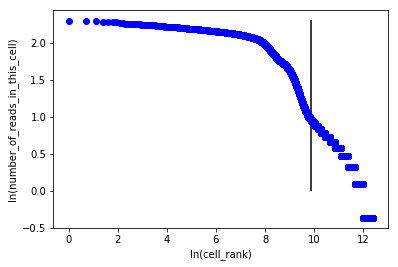

In [23]:
cellSizeReads=np.log(readInCell.loc[:,"count"])
rawdiff=np.diff(np.log(sorted(cellSizeReads,reverse=True)))/np.diff(range(len(cellSizeReads)))
inflPoin=np.argmin(rawdiff[1000:20000])+1000  #we know that there are more than 1000 cells and surely less than 20000

print(inflPoin)

plt.plot(np.log(range(len(cellSizeReads))),np.log(sorted(cellSizeReads,reverse=True)),"bo")
plt.xlabel("ln(cell_rank)")
plt.ylabel("ln(number_of_reads_in_this_cell)")
plt.vlines(np.log(inflPoin),0,np.log(sorted(cellSizeReads,reverse=True))[0])



In [31]:
%%time
print(time.ctime())
run_minnn_BC_correcttion(sampleName,newDirectory,inflPoin)
print(time.ctime())

Thu Feb  7 07:21:59 2019
Thu Feb  7 08:21:25 2019
CPU times: user 124 ms, sys: 52.8 ms, total: 177 ms
Wall time: 59min 26s


In [32]:
%%time
print(time.ctime())
run_minnn_stat_groups("corrected-"+str(sampleName),newDirectory)
print(time.ctime())

Thu Feb  7 08:21:25 2019
        minnn stat-groups -f                           --groups BC                           --input /home/taumata/shared-with-me/minnn_analysis/results/singlecell/tcr_minnn/corrected-tcr_minnn.mif                           --output /home/taumata/shared-with-me/minnn_analysis/results/singlecell/tcr_minnn/statgroup-corrected-tcr_minnn.txt
                          
Thu Feb  7 08:25:56 2019
CPU times: user 10.8 ms, sys: 30.5 ms, total: 41.3 ms
Wall time: 4min 30s


18244


/home/taumata/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


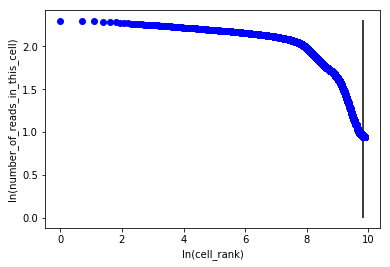

In [33]:
readInCell=pd.read_csv(str(newDirectory)+"/statgroup-corrected-"+str(sampleName)+".txt",
                                sep=" ",header=0)
cellSizeReads=np.log(readInCell.loc[:,"count"])
rawdiff=np.diff(np.log(sorted(cellSizeReads,reverse=True)))/np.diff(range(len(cellSizeReads)))
inflPoin=np.argmin(rawdiff[1000:20000])+1000  #we know that there are more than 1000 cells and surely less than 20000

print(inflPoin)

plt.plot(np.log(range(len(cellSizeReads))),np.log(sorted(cellSizeReads,reverse=True)),"bo")
plt.xlabel("ln(cell_rank)")
plt.ylabel("ln(number_of_reads_in_this_cell)")
plt.vlines(np.log(inflPoin),0,np.log(sorted(cellSizeReads,reverse=True))[0])



In [34]:
%%time
print(time.ctime())
run_minnn_sort(sampleName,newDirectory)
print(time.ctime())

Thu Feb  7 08:25:56 2019
Thu Feb  7 08:59:58 2019
CPU times: user 70.2 ms, sys: 30.8 ms, total: 101 ms
Wall time: 34min 2s


In [35]:
%%time
print(time.ctime())
run_minnn_UMI_correcttion(sampleName,newDirectory)
print(time.ctime())

Thu Feb  7 08:59:58 2019
        minnn correct -f             --primary-groups BC             --groups UMI               --input /home/taumata/shared-with-me/minnn_analysis/results/singlecell/tcr_minnn/sorted-tcr_minnn.mif               --output /home/taumata/shared-with-me/minnn_analysis/results/singlecell/tcr_minnn/UMI-corrected-tcr_minnn.mif 
    
Thu Feb  7 09:30:53 2019
CPU times: user 40.4 ms, sys: 48.1 ms, total: 88.5 ms
Wall time: 30min 54s


In [36]:
%%time
print(time.ctime())
run_minnn_sort_UMI(sampleName,newDirectory)
print(time.ctime())

Thu Feb  7 09:30:53 2019
Thu Feb  7 10:00:02 2019
CPU times: user 62.2 ms, sys: 33.6 ms, total: 95.9 ms
Wall time: 29min 9s


In [37]:
%%time
print(time.ctime())
run_minnn_consensus(sampleName,newDirectory)
print(time.ctime())

Thu Feb  7 10:00:02 2019
minnn consensus -Xmx60G -f                                             --groups BC UMI                                             --consensus-algorithm SINGLE_CELL                                             --threads 60                                             --input /home/taumata/shared-with-me/minnn_analysis/results/singlecell/tcr_minnn/UMI-sorted-tcr_minnn.mif                                             --output /home/taumata/shared-with-me/minnn_analysis/results/singlecell/tcr_minnn/UMI-consensus-tcr_minnn.mif                                             
Thu Feb  7 10:11:03 2019
CPU times: user 28.5 ms, sys: 31.8 ms, total: 60.3 ms
Wall time: 11min 1s


In [41]:
%%time
print(time.ctime())
run_minnn_mif2fastq_SHUNT_LAST(sampleName,newDirectory)
print(time.ctime())

Thu Feb  7 12:27:45 2019
 minnn mif2fastq -f                     --input /home/taumata/shared-with-me/minnn_analysis/results/singlecell/tcr_minnn/UMI-consensus-tcr_minnn.mif                     --group R1=/home/taumata/shared-with-me/minnn_analysis/results/singlecell/tcr_minnn/R1_final-tcr_minnn.fastq                      R2=/home/taumata/shared-with-me/minnn_analysis/results/singlecell/tcr_minnn/R2_final-tcr_minnn.fastq
Thu Feb  7 12:28:47 2019
CPU times: user 0 ns, sys: 38.2 ms, total: 38.2 ms
Wall time: 1min 1s


In [ ]:
demultiplex cells

In [ ]:
run mixcr

In [ ]:
combine

In [47]:
%%time
print(time.ctime())
initialDir=os.getcwd()
os.chdir("/home/taumata/shared-with-me/minnn_analysis/results/singlecell/tcr_minnn")
os.system("mixcr analyze amplicon -s hsa --starting-material rna \
                --5-end no-v-primers \
                --3-end j-c-intron-primers \
                --adapters adapters-present\
                R1_final-tcr_minnn.fastq R2_final-tcr_minnn.fastq tcr_minnn_mixcr")
os.chdir(initialDir)
print(time.ctime())

Thu Feb  7 14:10:49 2019
Thu Feb  7 14:15:52 2019
CPU times: user 8.75 ms, sys: 27.8 ms, total: 36.5 ms
Wall time: 5min 2s


In [46]:
%%time
os.system("/home/taumata/soft/STAR-2.5.4b/bin/Linux_x86_64/STAR \
                  --runThreadN 16 \
                  --genomeDir /home/taumata/GRCh38/GRCh38_STAR5idx \
                  --outFilterMultimapNmax 1 \
                  --outSAMtype BAM SortedByCoordinate \
                  --readFilesIn  /home/taumata/shared-with-me/minnn_analysis/results/singlecell/tcr_minnn/R1_final-tcr_minnn.fastq \
                                 /home/taumata/shared-with-me/minnn_analysis/results/singlecell/tcr_minnn/R2_final-tcr_minnn.fastq \
                  --outFileNamePrefix tcr_minnn_STAR")

CPU times: user 5.92 ms, sys: 26.3 ms, total: 32.2 ms
Wall time: 3min 40s


0

In [49]:
%%bash
/home/taumata/soft/subread-1.6.3-source/bin/featureCounts \
                  -a /home/taumata/GRCh38/Homo_sapiens.GRCh38.94.chr.gtf \
                  -o /home/taumata/shared-with-me/minnn_analysis/results/singlecell/tcr_minnn/gene_assigned_tcr_minnn \
                  -R CORE \
                  -T 60 \
                  -p \
                  /home/taumata/shared-with-me/minnn_analysis/results/singlecell/tcr_minnn/tcr_minnn_STARAligned.sortedByCoord.out.bam  



        ==========     _____ _    _ ____  _____  ______          _____  
        =====         / ____| |  | |  _ \|  __ \|  ____|   /\   |  __ \ 
          =====      | (___ | |  | | |_) | |__) | |__     /  \  | |  | |
            ====      \___ \| |  | |  _ <|  _  /|  __|   / /\ \ | |  | |
              ====    ____) | |__| | |_) | | \ \| |____ / ____ \| |__| |
        ==========   |_____/ \____/|____/|_|  \_\______/_/    \_\_____/
	  v1.6.3

//========================== featureCounts setting ===========================\\
||                                                                            ||
||             Input files : 1 BAM file                                       ||
||                           P tcr_minnn_STARAligned.sortedByCoord.out.bam    ||
||                                                                            ||
||             Output file : gene_assigned_tcr_minnn                          ||
||                 Summary : gene_assigned_tcr_minnn.summary     

### GENE EXPRESSOIN SAMPLE PAIRED WITH TCR ENRICHED SAMPLE

26bp read1 (including 16bp Chromium barcode and 10bp UMI), 91bp read2 (transcript), and 8bp I7 sample barcode read configuration for gene expression data; 28bp read1 (including 16bp Chromium barcode and 10bp UMI), 91bp read2 (Feature Barcode oligonucleotide), and 8bp I7 sample barcode read configuration for cell surface protein data

In [5]:
def run_minnn_extract_10xGE(R1,R2,outputName,workingDirectory):
    
    minnn_extract = """\
        minnn extract -f \
            --oriented \
            --score-threshold 0 \
              --bitap-max-errors 0 \
              --threads 60 \
              --pattern "^(FULL:(BC:NNNNNNNNNNNNNNNN)(UMI:NNNNNNNNNN))$\*" \
              --input %s %s \
              --output %s/extracted-%s.mif
    """%(R1,R2,workingDirectory,outputName)
    
    os.system(minnn_extract)


def run_minnn_BC_correcttion(outputName,workingDirectory):
    
    
    minnn_correct = """\
        minnn correct -f \
            --groups BC \
              --input %s/extracted-%s.mif \
              --output %s/corrected-%s.mif 
    """%(workingDirectory,outputName,
         workingDirectory, outputName)
    
    print(minnn_correct)
    os.system(minnn_correct)    
    
    
def run_minnn_stat_groups(sampleName,workingDirectory):
    
    minnn_stat_groups = """\
        minnn stat-groups -f \
                          --groups BC \
                          --input %s/%s.mif \
                          --output %s/statgroup-%s.txt
                          """%(workingDirectory,sampleName,
                              workingDirectory,sampleName)
    
    print(minnn_stat_groups)
    os.system(minnn_stat_groups)
    
    
def run_minnn_BC_filter(outputName,workingDirectory,maxBarcodes):
    
    
    minnn_correct = """\
        minnn correct -f \
            --groups BC \
              --max-total-errors 0 \
              --input %s/corrected-%s.mif \
              --output %s/filtred-%s.mif \
              --max-unique-barcodes %s
    """%(workingDirectory,outputName,
         workingDirectory, outputName,maxBarcodes)
    
    print(minnn_correct)
    os.system(minnn_correct)
        
def run_minnn_sort_BC(sampleName,workingDirectory):

    minnn_sort = """\
        minnn -Xmx100G sort \
            -f \
            --chunk-size 1000000\
            --groups BC \
            --input %s/filtred-%s.mif \
            --output %s/sorted-%s.mif
        """%(workingDirectory, sampleName,
             workingDirectory, sampleName)
    print(minnn_sort)
    os.system(minnn_sort)
        
def run_minnn_UMI_correcttion(sampleName,workingDirectory):
    
    
    minnn_correct = """\
        minnn correct -f \
            --primary-groups BC \
            --groups UMI \
              --input %s/sorted-%s.mif \
              --output %s/UMI-corrected-%s.mif 
    """%(workingDirectory,sampleName,
         workingDirectory, sampleName)
    
    print(minnn_correct)
    os.system(minnn_correct)

def run_minnn_sort_BC_UMI(sampleName,workingDirectory):

    minnn_sort = """\
        minnn -Xmx100G sort \
            -f \
            --chunk-size 1000000\
            --groups BC UMI\
            --input %s/UMI-corrected-%s.mif \
            --output %s/BC_UMI-sorted-%s.mif
        """%(workingDirectory, sampleName,
             workingDirectory, sampleName)
    
    os.system(minnn_sort)   
    
    
def run_minnn_consensus(sampleName,workingDirectory):
    
    minnn_consensus="""minnn consensus -Xmx60G -f \
                                            --groups BC UMI \
                                            --threads 60 \
                                            --input %s/BC_UMI-sorted-%s.mif \
                                            --output %s/consensus-%s.mif \
                                            """%(workingDirectory,sampleName,
                                                 workingDirectory,sampleName)
    
    
    print(minnn_consensus)
    os.system(minnn_consensus)     

In [6]:
R1="/home/taumata/shared-with-me/minnn_analysis/raw_data/singlecell/vdj_v1_hs_pbmc2_5gex_protein_fastqs/vdj_v1_hs_pbmc2_5gex_fastqs/ge_10x_R1.fastq.gz"
R2="/home/taumata/shared-with-me/minnn_analysis/raw_data/singlecell/vdj_v1_hs_pbmc2_5gex_protein_fastqs/vdj_v1_hs_pbmc2_5gex_fastqs/ge_10x_R2.fastq.gz"
sampleName="ge_minnn"
workingDirectory="/home/taumata/shared-with-me/minnn_analysis/results/singlecell"
#---------------------------------------
newDirectory=str(workingDirectory)+"/"+str(sampleName) #will be used from demultiplexing step
try:
    os.mkdir(str(newDirectory))
except:
    pass

In [7]:
%%time
print(time.ctime())
run_minnn_extract_10xGE(R1,R2,sampleName,newDirectory)
print(time.ctime())

Sun Feb 24 21:57:10 2019
Sun Feb 24 23:14:05 2019
CPU times: user 178 ms, sys: 58 ms, total: 236 ms
Wall time: 1h 16min 55s


Sun Feb 24 23:14:05 2019
        minnn stat-groups -f                           --groups BC                           --input /home/taumata/shared-with-me/minnn_analysis/results/singlecell/ge_minnn/extracted-ge_minnn.mif                           --output /home/taumata/shared-with-me/minnn_analysis/results/singlecell/ge_minnn/statgroup-extracted-ge_minnn.txt
                          
Sun Feb 24 23:58:18 2019
8789


/home/taumata/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


CPU times: user 20.2 s, sys: 1.11 s, total: 21.3 s
Wall time: 44min 18s


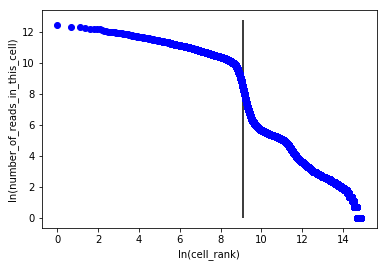

In [8]:
%%time
print(time.ctime())
run_minnn_stat_groups("extracted-"+str(sampleName),newDirectory)
print(time.ctime())

readInCell=pd.read_csv(str(newDirectory)+"/statgroup-extracted-"+str(sampleName)+".txt",
                                sep=" ",header=0)
#readInCell.loc[:,"logCount"]=np.log(readInCell.loc[:,"count"])
cellSizeReads=np.log(readInCell.loc[:,"count"])
rawdiff=np.diff(np.log(sorted(cellSizeReads,reverse=True)))/np.diff(range(len(cellSizeReads)))
inflPoin=np.argmin(rawdiff[1000:20000])+1000  #we know that there are more than 1000 cells and surely less than 20000

print(inflPoin)

plt.plot(np.log(range(len(cellSizeReads))),sorted(cellSizeReads,reverse=True),"bo")
plt.xlabel("ln(cell_rank)")
plt.ylabel("ln(number_of_reads_in_this_cell)")
plt.vlines(np.log(inflPoin),0,sorted(cellSizeReads,reverse=True)[0])

In [9]:
%%time
print(time.ctime())
run_minnn_BC_correcttion(sampleName,newDirectory)
print(time.ctime())

Sun Feb 24 23:58:38 2019
        minnn correct -f             --groups BC               --input /home/taumata/shared-with-me/minnn_analysis/results/singlecell/ge_minnn/extracted-ge_minnn.mif               --output /home/taumata/shared-with-me/minnn_analysis/results/singlecell/ge_minnn/corrected-ge_minnn.mif 
    
Mon Feb 25 06:15:27 2019
CPU times: user 694 ms, sys: 322 ms, total: 1.02 s
Wall time: 6h 16min 49s


Mon Feb 25 06:15:27 2019
        minnn stat-groups -f                           --groups BC                           --input /home/taumata/shared-with-me/minnn_analysis/results/singlecell/ge_minnn/corrected-ge_minnn.mif                           --output /home/taumata/shared-with-me/minnn_analysis/results/singlecell/ge_minnn/statgroup-corrected-ge_minnn.txt
                          
Mon Feb 25 06:41:43 2019
1026
CPU times: user 221 ms, sys: 228 ms, total: 449 ms
Wall time: 26min 16s


/home/taumata/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


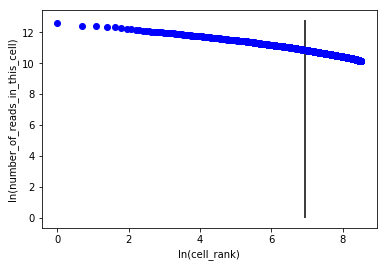

In [10]:
%%time
print(time.ctime())
run_minnn_stat_groups("corrected-"+str(sampleName),newDirectory)
print(time.ctime())

readInCell=pd.read_csv(str(newDirectory)+"/statgroup-corrected-"+str(sampleName)+".txt",
                                sep=" ",header=0)
#readInCell.loc[:,"logCount"]=np.log(readInCell.loc[:,"count"])
cellSizeReads=np.log(readInCell.loc[:,"count"])
rawdiff=np.diff(np.log(sorted(cellSizeReads,reverse=True)))/np.diff(range(len(cellSizeReads)))
inflPoin=np.argmin(rawdiff[1000:20000])+1000  #we know that there are more than 1000 cells and surely less than 20000

print(inflPoin)

plt.plot(np.log(range(len(cellSizeReads))),sorted(cellSizeReads,reverse=True),"bo")
plt.xlabel("ln(cell_rank)")
plt.ylabel("ln(number_of_reads_in_this_cell)")
plt.vlines(np.log(inflPoin),0,sorted(cellSizeReads,reverse=True)[0])


#### skip filtration stage, just "rename" file

In [ ]:
# %%time
# print(time.ctime())
# run_minnn_BC_filter(sampleName,newDirectory,inflPoin)
# print(time.ctime())

In [15]:
%%bash
cp /home/taumata/shared-with-me/minnn_analysis/results/singlecell/ge_minnn/corrected-ge_minnn.mif /home/taumata/shared-with-me/minnn_analysis/results/singlecell/ge_minnn/filtred-ge_minnn.mif

In [16]:
%%time
print(time.ctime())
run_minnn_sort_BC(sampleName,newDirectory)
print(time.ctime())

Mon Feb 25 09:48:50 2019
        minnn -Xmx100G sort             -f             --chunk-size 1000000            --groups BC             --input /home/taumata/shared-with-me/minnn_analysis/results/singlecell/ge_minnn/filtred-ge_minnn.mif             --output /home/taumata/shared-with-me/minnn_analysis/results/singlecell/ge_minnn/sorted-ge_minnn.mif
        
Mon Feb 25 12:22:45 2019
CPU times: user 289 ms, sys: 155 ms, total: 444 ms
Wall time: 2h 33min 55s


In [19]:
%%time
print(time.ctime())
run_minnn_UMI_correcttion(sampleName,newDirectory)
print(time.ctime())

Tue Feb 26 07:10:35 2019
        minnn correct -f             --primary-groups BC             --groups UMI               --input /home/taumata/shared-with-me/minnn_analysis/results/singlecell/ge_minnn/sorted-ge_minnn.mif               --output /home/taumata/shared-with-me/minnn_analysis/results/singlecell/ge_minnn/UMI-corrected-ge_minnn.mif 
    
Tue Feb 26 20:57:58 2019
CPU times: user 1.19 s, sys: 666 ms, total: 1.85 s
Wall time: 13h 47min 22s


In [20]:
%%time
print(time.ctime())
run_minnn_sort_BC_UMI(sampleName,newDirectory)
print(time.ctime())

Tue Feb 26 23:48:03 2019
Wed Feb 27 01:45:45 2019
CPU times: user 189 ms, sys: 138 ms, total: 327 ms
Wall time: 1h 57min 42s


In [21]:
%%time
print(time.ctime())
run_minnn_consensus(sampleName,newDirectory)
print(time.ctime())

Wed Feb 27 01:45:46 2019
minnn consensus -Xmx60G -f                                             --groups BC UMI                                             --threads 60                                             --input /home/taumata/shared-with-me/minnn_analysis/results/singlecell/ge_minnn/BC_UMI-sorted-ge_minnn.mif                                             --output /home/taumata/shared-with-me/minnn_analysis/results/singlecell/ge_minnn/consensus-ge_minnn.mif                                             
Wed Feb 27 03:23:43 2019
CPU times: user 198 ms, sys: 121 ms, total: 319 ms
Wall time: 1h 37min 57s


In [ ]:
#KALLISTO

In [ ]:
%%time
os.system("/home/taumata/soft/STAR-2.5.4b/bin/Linux_x86_64/STAR \
                  --runThreadN 16 \
                  --genomeDir /home/taumata/GRCh38/GRCh38_STAR5idx \
                  --outFilterMultimapNmax 1 \
                  --outSAMtype BAM SortedByCoordinate \
                  --readFilesIn  /home/taumata/shared-with-me/minnn_analysis/results/singlecell/tcr_minnn/R1_final-tcr_minnn.fastq \
                                 /home/taumata/shared-with-me/minnn_analysis/results/singlecell/tcr_minnn/R2_final-tcr_minnn.fastq \
                  --outFileNamePrefix tcr_minnn_STAR")